# Time series data science project

- **Chess players patterns discovery and analysis**
- **ariel-zil**

## Part 1 : EDA

# 1. Problem decription

[chess](https://en.wikipedia.org/wiki/Chess), one of the most known games in the world is regularaly played by multiple people accross the world.

There are couple of known chess variants:
- **Blitz Chess and Bullet Chess**: These are faster versions of traditional chess. Blitz games typically allow 3 to 5 minutes for each player for all their moves, while bullet games might have even shorter times, such as 1 or 2 minutes.
- **Chess960 (Fischer Random Chess)**: Invented by former World Chess Champion Bobby Fischer, Chess960 starts with a random positioning of the non-pawn pieces on the first rank, with the placement of pieces mirrored on both sides. This variation has 960 possible starting positions, significantly reducing the reliance on opening preparation.
- **Xiangqi (Chinese Chess)**: While derived from the same Indian game as international chess, Xiangqi includes different pieces, a board with the "river" in the middle, and specific areas called "fortresses" for the generals (kings). It is massively popular in China and has different strategic principles.
- **Shogi (Japanese Chess)**: Shogi features a drop rule, allowing captured pieces to be returned to the board under the captor's control. This variant is characterized by its almost limitless possibilities for gameplay, as pieces can re-enter play rather than being permanently removed.

**Hopefully this work will try to uncover patterns on those games(depending on time constains)**

## 1.2 What does this work studies?
* This work tries to uncover various patterns in chess players skill over a period of time
* This work will focus on [ELO](https://en.wikipedia.org/wiki/Elo_rating_system) as a measure of the players skill

## 1.3 Datasets 

In this project we have tested  various chess datasets:

 1. [free indepeded chess server games from 2018 to 2020 blitz variant](https://www.kaggle.com/datasets/arielzilber/fics-2018-2020-blitz)

 2. [free indepeded chess server games from 2009 to 2023 standard variant](https://www.kaggle.com/datasets/arielzilber/fcis-standard-2009-to-2023)

**this notebook explores the first dataset**


 The datasetset contains many unneeded columns and so we will remove them and save the cleaned dataset
 

## 1.4 Questions to answer 


- What game strategy patterns are common in players
- How to diffrentiate betweeen a good player and a bad one

# 2. Imports

## 2.1 Import packages

In [1]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
import time
from sklearn import metrics
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import numpy as np
from warnings import filterwarnings
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from collections import Counter
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = 10,6
base_color = sb.color_palette()[0]




filterwarnings("ignore")

## 2.2 Load enviroment variables

In [2]:
PROJECT_PATH=os.getenv('PROJECT_PATH')
NUMBER_OF_GAMES_MINIMUM=int(os.getenv('NUMBER_OF_GAMES_MINIMUM'))
FICS_MIN_YEAR=int(os.getenv('FICS_MIN_YEAR'))
FICS_MAX_YEAR=int(os.getenv('FICS_MAX_YEAR'))

# 3. Basic data cleaning

In this section we will open the free independed chess server dataset which we will use.

This work has tested various datasets:

 1. [free indepeded chess server games from 2018 to 2020 blitz variant](https://www.kaggle.com/datasets/arielzilber/fics-2018-2020-blitz)

 2. [free indepeded chess server games from 2009 to 2023 standard variant](https://www.kaggle.com/datasets/arielzilber/fcis-standard-2009-to-2023)

**this notebook explores the second dataset**


 The datasetset contains many unneeded columns and so we will remove them and save the cleaned dataset

## 3.1 Load dataset

In [5]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics/proccessed/chess-games.csv")
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Event,Site,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,...,Date,Time,WhiteClock,BlackClock,ECO,PlyCount,Result,Move,WhiteIsComp,BlackIsComp
0,0,0,0,FICS rated blitz game,FICS freechess.org,455505130,Strikko,boggus,1606,1607,...,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A27,156,0-1,| Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...,NaN,NaN
1,1,1,0,FICS rated blitz game,FICS freechess.org,455505129,Wychbold,Jarlaxle,1311,1437,...,2019.11.30,08:07:00,0:03:00.000,0:03:00.000,B21,60,0-1,| e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...,NaN,NaN
2,2,2,0,FICS rated blitz game,FICS freechess.org,455505128,Shaderman,tihibuda,1567,1516,...,2019.11.30,08:06:00,0:03:00.000,0:03:00.000,B06,75,1-0,| e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...,NaN,NaN
3,3,3,0,FICS rated blitz game,FICS freechess.org,455505126,aussenschnapp,SchachDieter,1680,1698,...,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A43,109,1-0,| d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...,NaN,NaN
4,4,4,0,FICS rated blitz game,FICS freechess.org,455505123,pfink,Tojul,1288,1174,...,2019.11.30,07:56:00,0:10:00.000,0:10:00.000,B94,71,0-1,| e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14717855,6004708,9996,0,FICS rated blitz game,FICS freechess.org,434845469,Arembepe,bretteux,1059,1155,...,2018.08.09,12:16:00,0:03:00.000,0:03:00.000,B20,47,1-0,| e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...,NaN,NaN
14717856,6004709,9997,0,FICS rated blitz game,FICS freechess.org,434845468,JonotheRed,HWPer,1501,1520,...,2018.08.09,12:12:00,0:05:00.000,0:05:00.000,C01,109,1-0,| e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...,NaN,NaN
14717857,6004710,9998,0,FICS rated blitz game,FICS freechess.org,434845467,snackking,Jonfern,1621,1676,...,2018.08.09,12:13:00,0:03:00.000,0:03:00.000,C50,80,0-1,| e4 e5 | Nf3 Nc6 | Bc4 Be7 | O-O Nf6 | Re1 O-...,NaN,NaN
14717858,6004711,9999,0,FICS rated blitz game,FICS freechess.org,434845465,alza,Jesuslovesall,1333,1423,...,2018.08.09,12:14:00,0:05:00.000,0:05:00.000,B01,42,0-1,| e4 d5 | e5 c5 | d4 Nc6 | dxc5 Nxe5 | Nf3 Nc6...,NaN,NaN


## 3.2 Remove columns

In [6]:
for c in [c for c in list(df.columns) if "Unnamed" in c]:
    df=df.drop(columns=c)
    
df["Year"]=df["Date"].apply(lambda r:r.split(".")[0])
df=df.drop(columns="Site")
df=df.drop(columns="WhiteIsComp")
df=df.drop(columns="BlackIsComp")
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean.csv")

# 4. Basic data exploration


## 4.1. Win rate

In this section we will check the effect of ELO rating on the winning rate

In [3]:
def win_rate_by_elo_diff(df,elo_diff):
    try:
        win_freq=Counter(df[df["EloDiff"] > elo_diff]["Result"])
        white_won=win_freq["1-0"]
        draw=win_freq["1/2-1/2"]
        black_won=win_freq["0-1"]
        total=white_won+draw+black_won
        white_wins_proportion = white_won / total
        white_loss_proportion = black_won / total
        draw_proportion = draw / total
        return pd.DataFrame({
            'EloDiff':[elo_diff],
            'TotalGames':[total],
            'WhiteWon':[white_won],
            'WhiteWinsProportion':[white_wins_proportion],
            'WhiteLossProportion':[white_loss_proportion],
            'BlackWon':[black_won],
            'Draw':[draw],
            'DrawProportion':[draw_proportion],
        })
    except Exception as err:
           return pd.DataFrame({
            'EloDiff':[ ],
            'TotalGames':[ ],
            'WhiteWon':[ ],
            'WhiteWinsProportion':[ ],
            'WhiteLossProportion':[ ],
            'BlackWon':[ ],
            'Draw':[ ],
            'DrawProportion':[ ],
        })
    
def win_rate_by_elo_diff_range(df,min_elo_diff,max_elo_diff):
    try:
        win_freq=Counter(df[(df["EloDiff"] >= min_elo_diff)&(df["EloDiff"] <= max_elo_diff)]["Result"])
        white_won=win_freq["1-0"]
        draw=win_freq["1/2-1/2"]
        black_won=win_freq["0-1"]
        total=white_won+draw+black_won
        white_wins_proportion = white_won / total
        white_loss_proportion = black_won / total
        draw_proportion = draw / total
        return pd.DataFrame({
            'EloDiff':[str(min_elo_diff)+","+str(max_elo_diff)],
            'TotalGames':[total],
            'WhiteWon':[white_won],
            'WhiteWinsProportion':[white_wins_proportion],
            'WhiteLossProportion':[white_loss_proportion],
            'BlackWon':[black_won],
            'Draw':[draw],
            'DrawProportion':[draw_proportion],
        })
    except Exception as err:
           return pd.DataFrame({
            'EloDiff':[ ],
            'TotalGames':[ ],
            'WhiteWon':[ ],
            'WhiteWinsProportion':[ ],
            'WhiteLossProportion':[ ],
            'BlackWon':[ ],
            'Draw':[ ],
            'DrawProportion':[ ],
        })

In [8]:
df["EloDiff"] = df["WhiteElo"] - df["BlackElo"]
df["RelativeEloDiff"] = (
    ((df["WhiteElo"] / (df[["WhiteElo", "BlackElo"]].median(axis=1))) - 1.0) * 100.0
).round(2)
display(df.head())

,Event,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,WhiteRD,BlackRD,TimeControl,Date,Time,WhiteClock,BlackClock,ECO,PlyCount,Result,Move,Year,EloDiff,RelativeEloDiff
0,FICS rated blitz game,455505130,Strikko,boggus,1606,1607,23.3,22.4,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A27,156,0-1,| Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...,2019,-1,-0.03
1,FICS rated blitz game,455505129,Wychbold,Jarlaxle,1311,1437,27.7,24.1,180+0,2019.11.30,08:07:00,0:03:00.000,0:03:00.000,B21,60,0-1,| e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...,2019,-126,-4.59
2,FICS rated blitz game,455505128,Shaderman,tihibuda,1567,1516,53.1,27.5,180+0,2019.11.30,08:06:00,0:03:00.000,0:03:00.000,B06,75,1-0,| e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...,2019,51,1.65
3,FICS rated blitz game,455505126,aussenschnapp,SchachDieter,1680,1698,19.5,22.9,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A43,109,1-0,| d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...,2019,-18,-0.53
4,FICS rated blitz game,455505123,pfink,Tojul,1288,1174,26.2,46.2,600+0,2019.11.30,07:56:00,0:10:00.000,0:10:00.000,B94,71,0-1,| e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...,2019,114,4.63


<Figure size 1200x800 with 0 Axes>

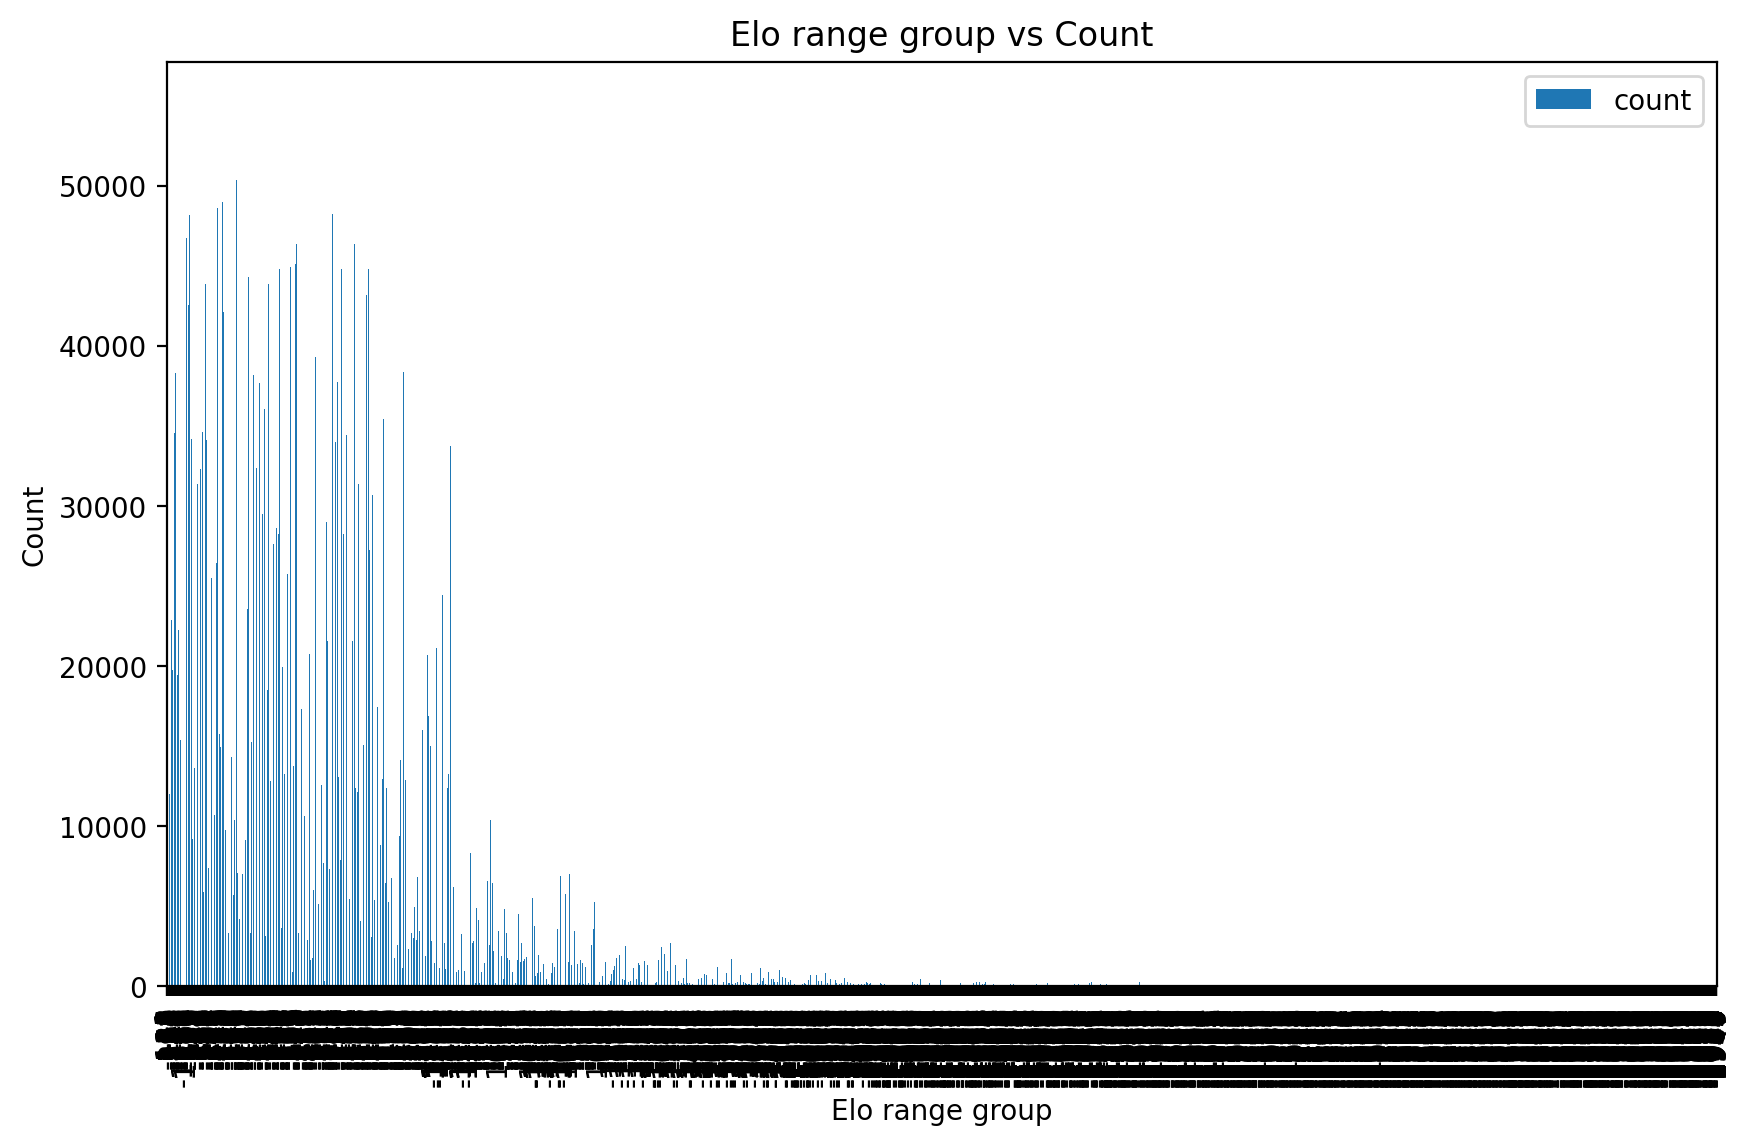

In [10]:
diffs=Counter(list(df["EloDiff"]))

freq_d={
    "amount":[],
    "count":[],
}

for k,v in diffs.items():
    freq_d["amount"].append(k)
    freq_d["count"].append(v)
    
df_freq=pd.DataFrame.from_dict(freq_d)
plt.figure(figsize=(12, 8))
ax=df_freq.plot(kind='bar',x='amount',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")
ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-Value-range-group-vs-count.png")

### Elo range group vs frequncy

Text(0.5, 1.0, 'Elo range group vs Count')

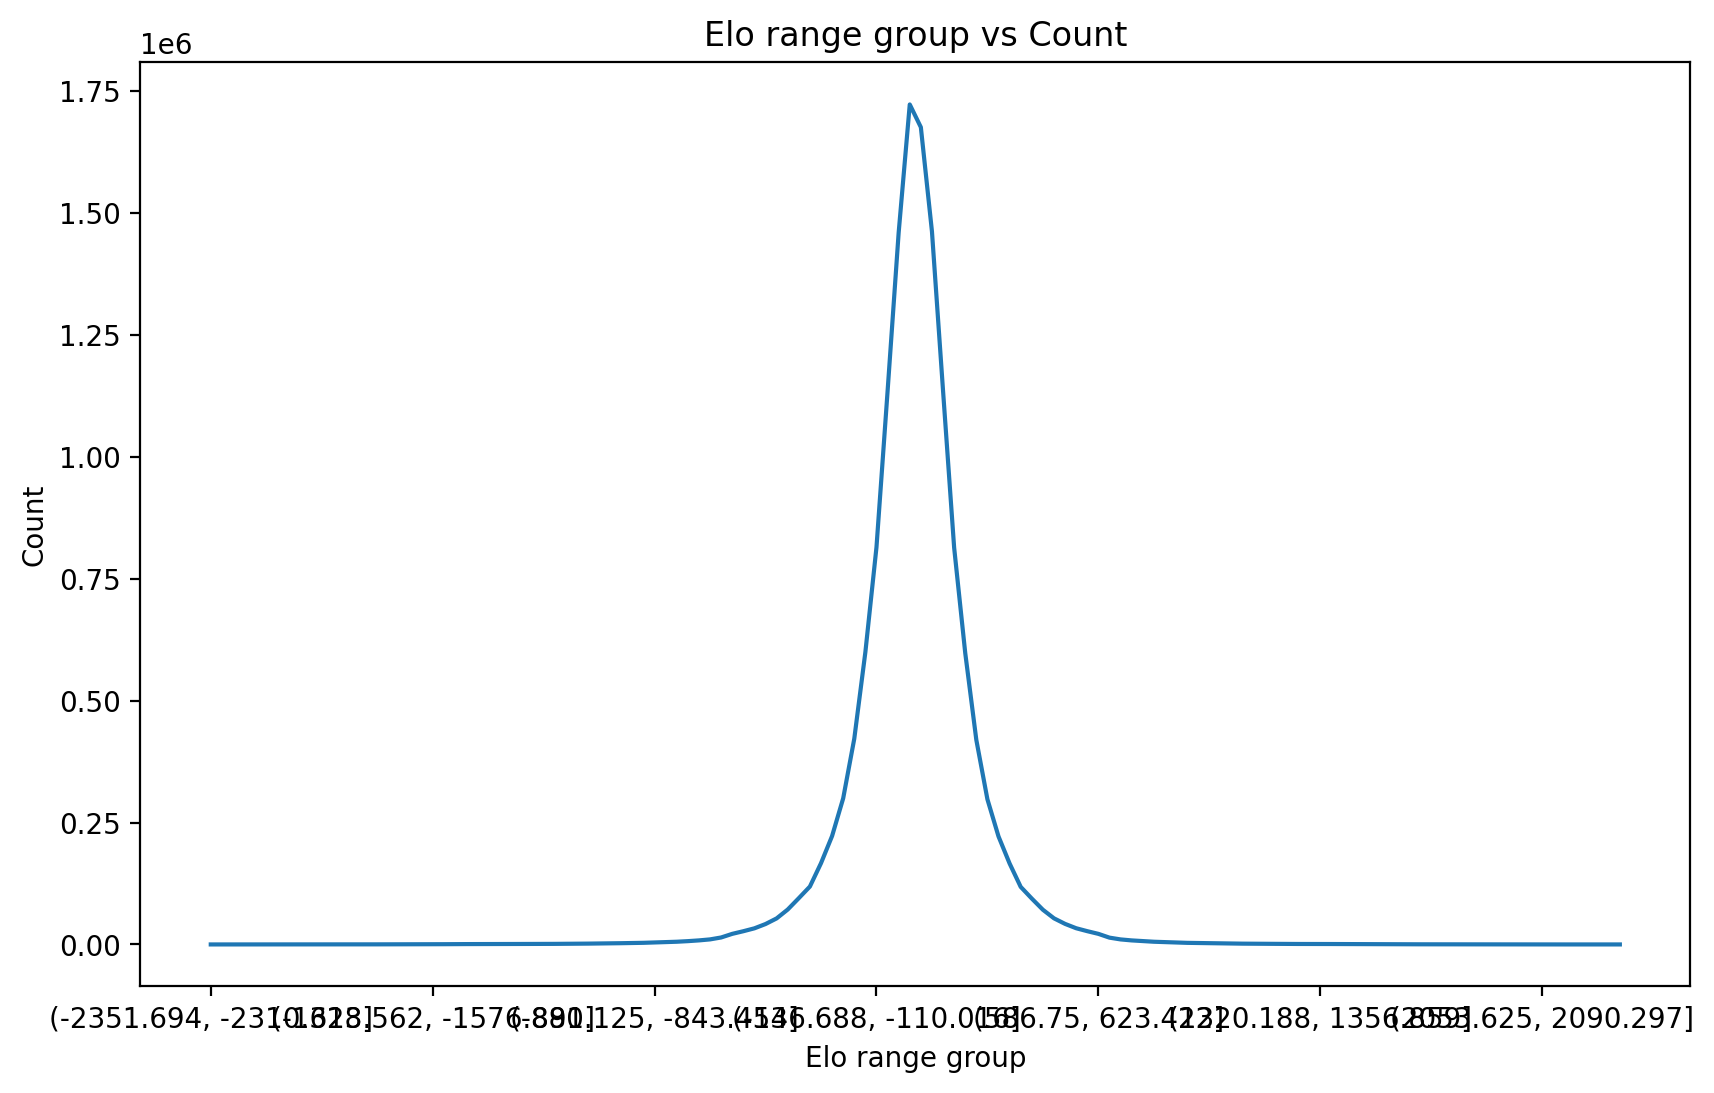

<Figure size 1200x2000 with 0 Axes>

In [11]:
categories = pd.cut(list(df["EloDiff"]), bins=128)
frequency_distribution = categories.value_counts()
ax=frequency_distribution.plot()
plt.figure(figsize=(12, 20))
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")

In [4]:
def get_elo_freq(df):
    freq_elo_black=Counter(list(df["BlackElo"]))
    freq_elo_white=Counter(list(df["WhiteElo"]))
    both={}
    for k,v in freq_elo_black.items():
        both[k]=v

    for k,v in freq_elo_white.items():
        both[k]=both.get(k,0)+v
    keys=list(both.keys())
    vals=list(both.values())
    frame=pd.DataFrame({
        'Elo':keys,
        'Count':vals,
    }).sort_values('Count',ascending=True)
    return frame

In [5]:
ELO_GROUPS={
     "Class J":[100,199],
     "Class I":[200,399],
     "Class H":[400,599],
     "Class H":[600,799],
     "Class F":[800,999],
     "Class E":[1000,1199],
     "Class D":[1200,1399],
     "Class C":[1400,1599],
     "Class B":[1600,1799],
     "Class A":[1800,1999],
     "Expert":[2000,2199],
     "National Master":[2200,2399],
     "Senior Master":[2400,3500],
}

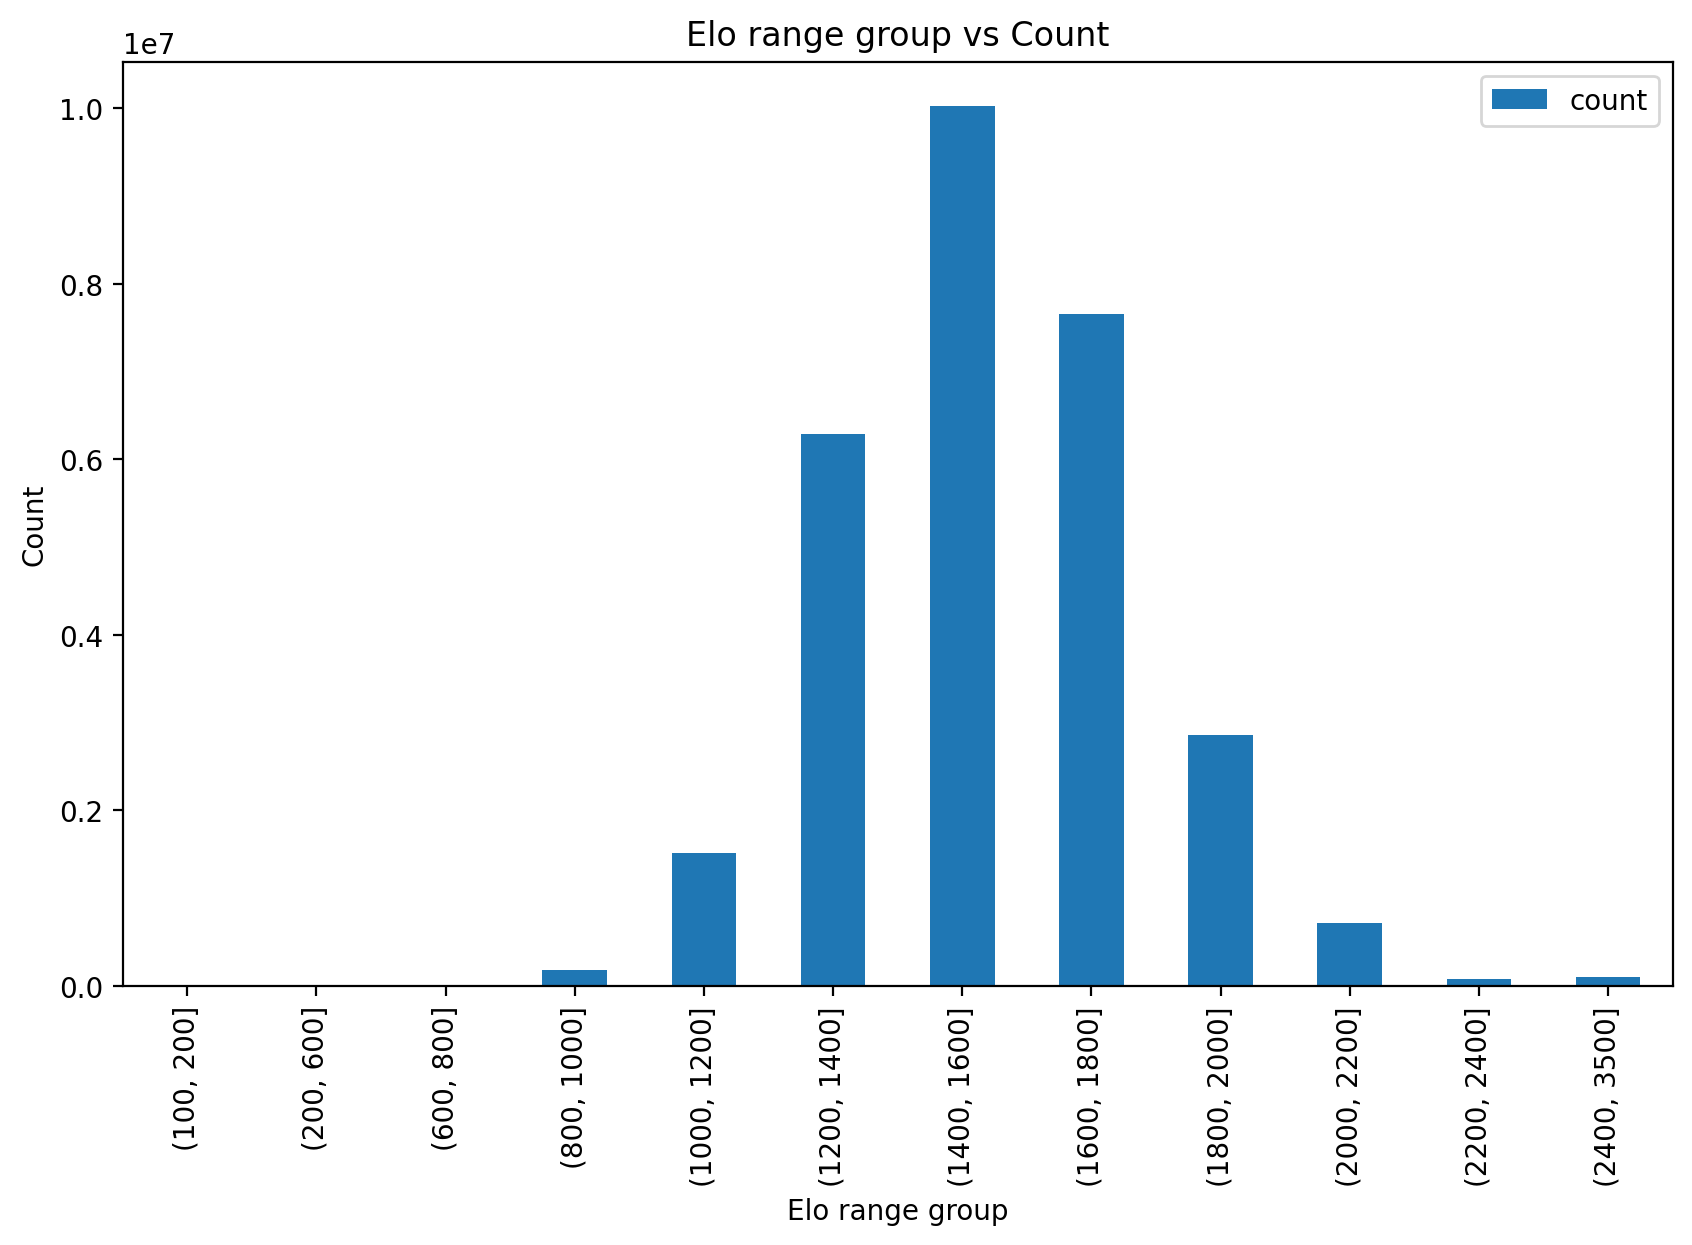

In [14]:
elo_freq=get_elo_freq(df)
elo_freq=elo_freq[["Elo","Count"]]
rating_bins = [v[0] for v in list(ELO_GROUPS.values())]+[3500]
rating_bins=sorted(rating_bins)
cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
elo_freq["group"]=cuts
groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
ax=elo_freq.plot(kind='bar',x='group',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")
ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-all-years.png")

### Elo win probability by diff

-------------------------------------------------- Player ratio --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,100.0,3330702.0,2417545.0,0.725836,0.240697,801690.0,111467.0,0.033467
0,200.0,1436578.0,1170727.0,0.814941,0.158484,227675.0,38176.0,0.026574
0,600.0,94510.0,90734.0,0.960047,0.032959,3115.0,661.0,0.006994
0,800.0,38619.0,37910.0,0.981641,0.014423,557.0,152.0,0.003936
0,1000.0,19612.0,19403.0,0.989343,0.007801,153.0,56.0,0.002855
0,1200.0,10978.0,10916.0,0.994352,0.003826,42.0,20.0,0.001822
0,1400.0,5847.0,5831.0,0.997264,0.002223,13.0,3.0,0.000513
0,1600.0,2313.0,2308.0,0.997838,0.002162,5.0,0.0,0.000000
0,1800.0,693.0,693.0,1.000000,0.000000,0.0,0.0,0.000000
0,2000.0,129.0,129.0,1.000000,0.000000,0.0,0.0,0.000000


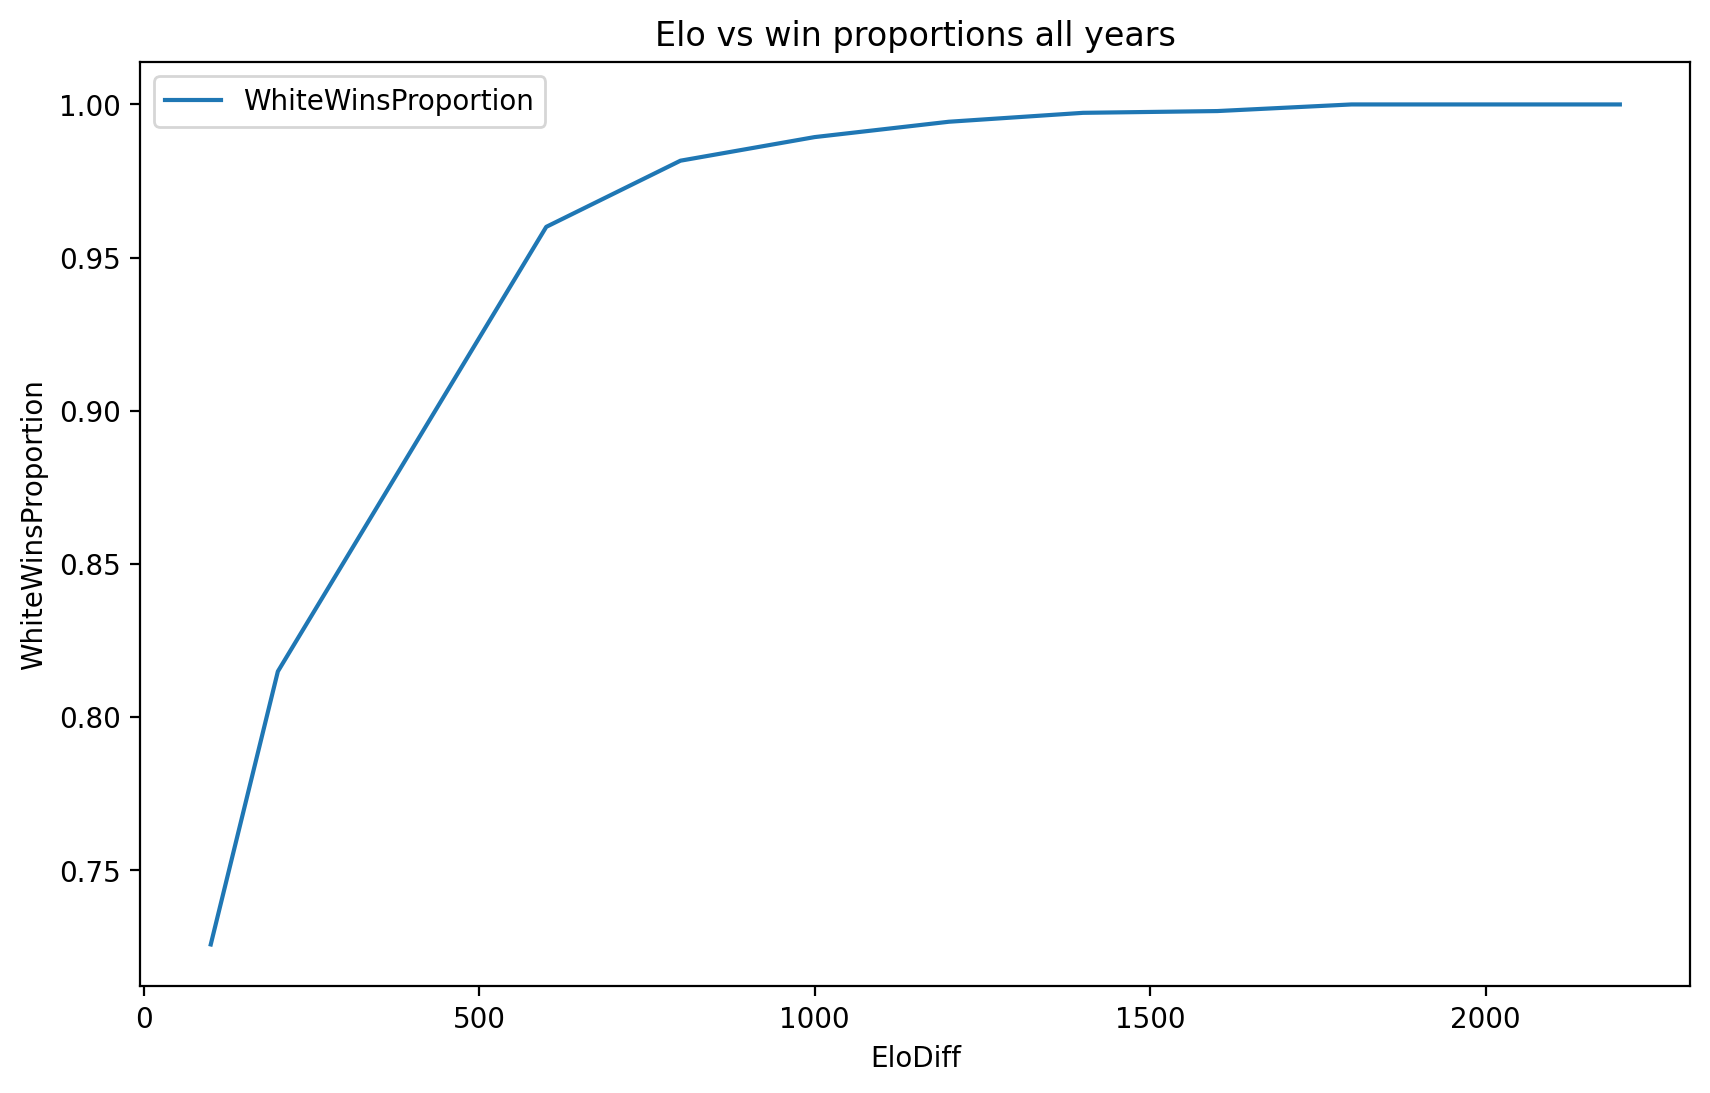

In [15]:
frames=[]

rating_bins = [v[0] for v in list(ELO_GROUPS.values())]+[3500]
for diff in rating_bins:
    frames.append(win_rate_by_elo_diff(df,diff))

frames_df=pd.concat(frames)
print("-"*50,"Player ratio","-"*50)
display(frames_df)
ax= frames_df.plot.line(x='EloDiff', y='WhiteWinsProportion')

ax.set_xlabel("EloDiff")
ax.set_ylabel("WhiteWinsProportion")
ax.set_title("Elo vs win proportions all years")

ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-vs-win-proportions-all-years.png")

### Win rate by elo diff for each year

-------------------------------------------------- Player ratio for year 2018 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,"100,199",769017.0,505292.0,0.657062,0.305204,234707.0,29018.0,0.037734
0,"200,399",431067.0,336354.0,0.780282,0.189312,81606.0,13107.0,0.030406
0,"600,799",22284.0,20970.0,0.941034,0.049497,1103.0,211.0,0.009469
0,"800,999",7673.0,7428.0,0.968070,0.026456,203.0,42.0,0.005474
0,"1000,1199",3723.0,3670.0,0.985764,0.009670,36.0,17.0,0.004566
0,"1200,1399",2529.0,2510.0,0.992487,0.005536,14.0,5.0,0.001977
0,"1400,1599",1465.0,1458.0,0.995222,0.002730,4.0,3.0,0.002048
0,"1600,1799",703.0,700.0,0.995733,0.004267,3.0,0.0,0.000000
0,"1800,1999",228.0,228.0,1.000000,0.000000,0.0,0.0,0.000000
0,"2000,2199",40.0,40.0,1.000000,0.000000,0.0,0.0,0.000000


-------------------------------------------------- Player ratio for year 2019 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,"100,199",626872.0,412076.0,0.657353,0.304253,190728.0,24068.0,0.038394
0,"200,399",363331.0,283916.0,0.781425,0.187991,68303.0,11112.0,0.030584
0,"600,799",18674.0,17719.0,0.948859,0.041823,781.0,174.0,0.009318
0,"800,999",6829.0,6682.0,0.978474,0.018158,124.0,23.0,0.003368
0,"1000,1199",2965.0,2901.0,0.978415,0.019562,58.0,6.0,0.002024
0,"1200,1399",1611.0,1596.0,0.990689,0.004966,8.0,7.0,0.004345
0,"1400,1599",1109.0,1107.0,0.998197,0.001803,2.0,0.0,0.000000
0,"1600,1799",419.0,419.0,1.000000,0.000000,0.0,0.0,0.000000
0,"1800,1999",135.0,135.0,1.000000,0.000000,0.0,0.0,0.000000
0,"2000,2199",26.0,26.0,1.000000,0.000000,0.0,0.0,0.000000


-------------------------------------------------- Player ratio for year 2020 --------------------------------------------------


,EloDiff,TotalGames,WhiteWon,WhiteWinsProportion,WhiteLossProportion,BlackWon,Draw,DrawProportion
0,"100,199",514482.0,337975.0,0.656923,0.302366,155562.0,20945.0,0.040711
0,"200,399",312236.0,245383.0,0.785890,0.183326,57241.0,9612.0,0.030784
0,"600,799",15634.0,14816.0,0.947678,0.044263,692.0,126.0,0.008059
0,"800,999",4664.0,4543.0,0.974057,0.018868,88.0,33.0,0.007075
0,"1000,1199",1930.0,1897.0,0.982902,0.009845,19.0,14.0,0.007254
0,"1200,1399",1045.0,1032.0,0.987560,0.007656,8.0,5.0,0.004785
0,"1400,1599",966.0,964.0,0.997930,0.002070,2.0,0.0,0.000000
0,"1600,1799",503.0,501.0,0.996024,0.003976,2.0,0.0,0.000000
0,"1800,1999",205.0,205.0,1.000000,0.000000,0.0,0.0,0.000000
0,"2000,2199",55.0,55.0,1.000000,0.000000,0.0,0.0,0.000000


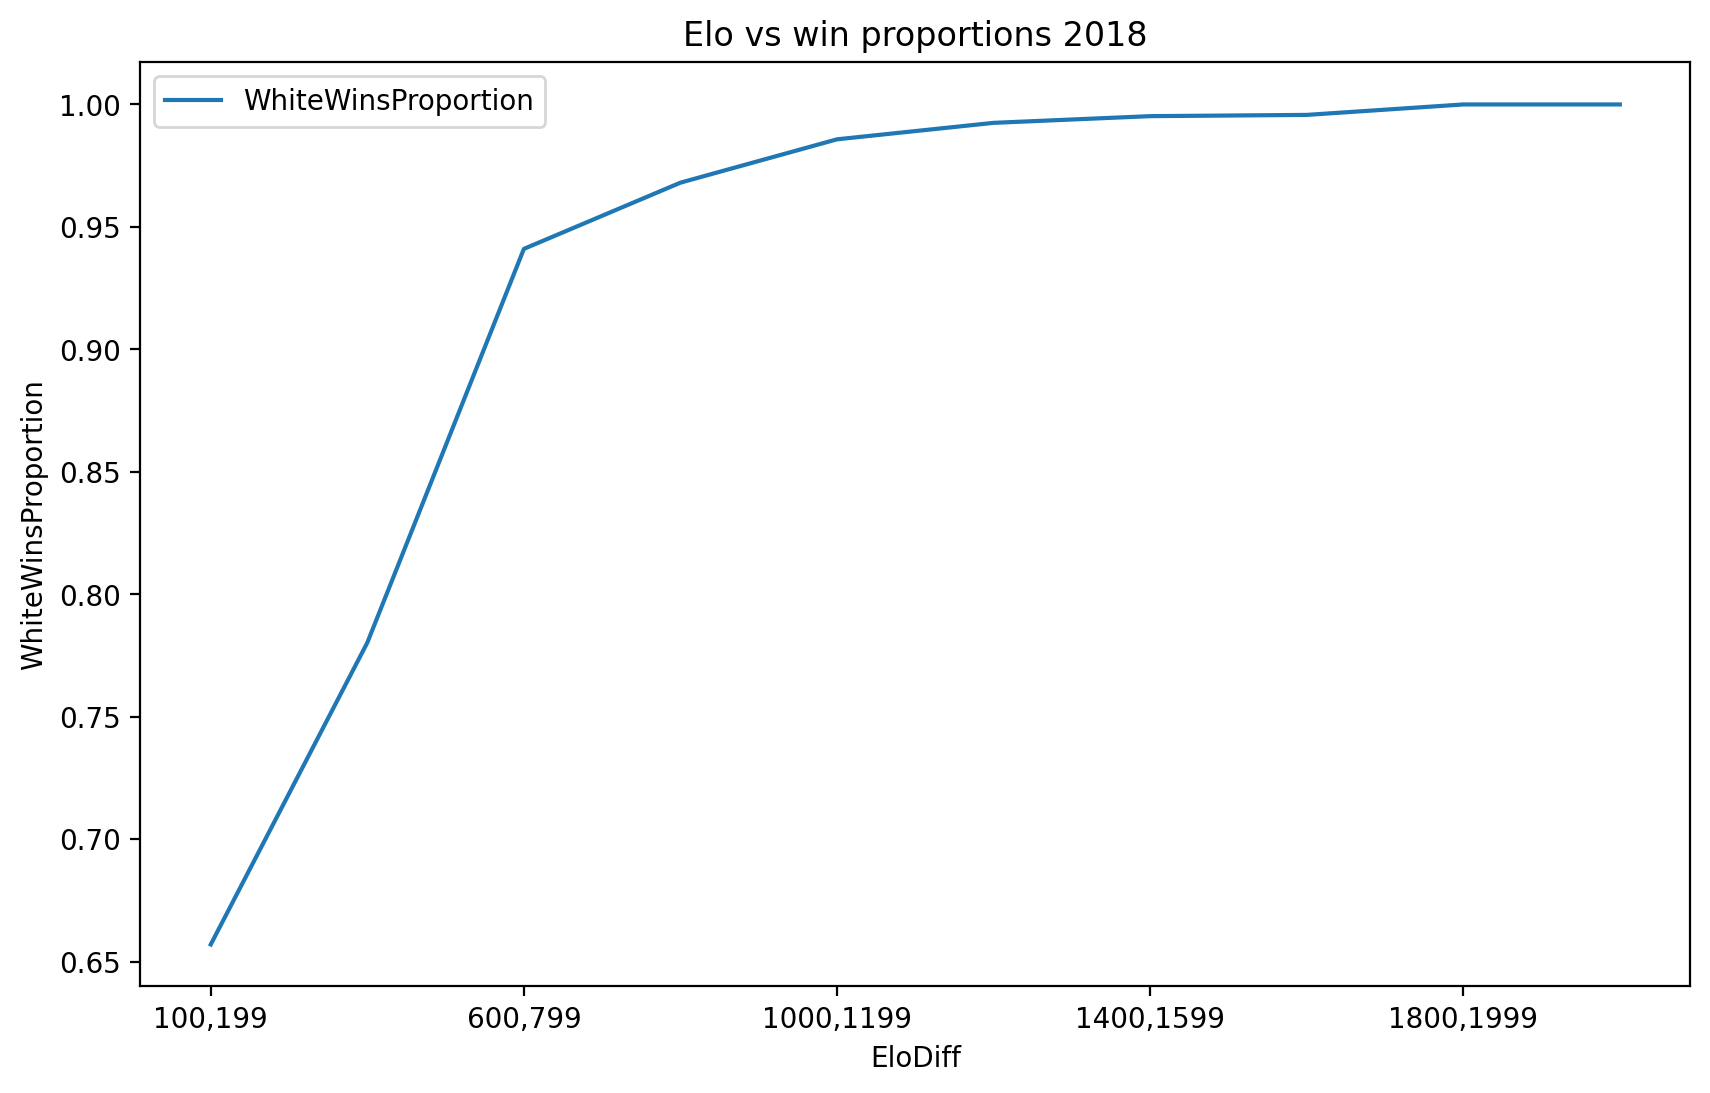

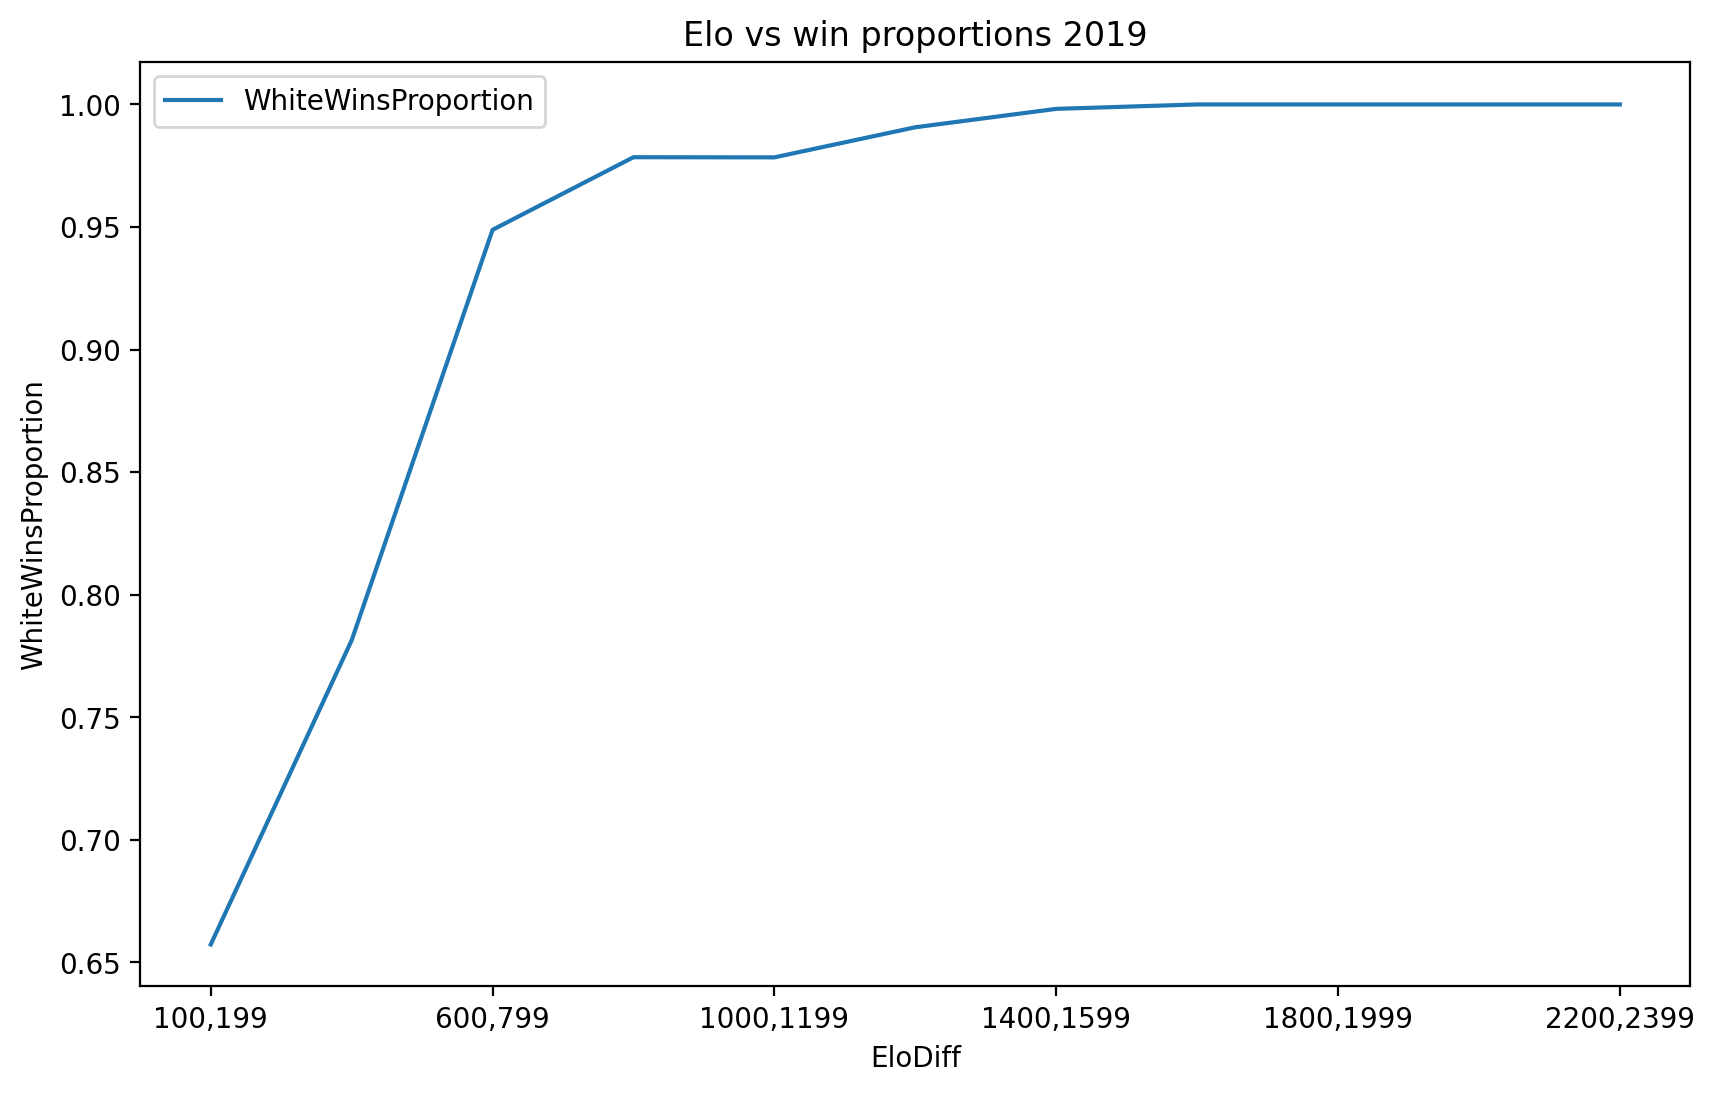

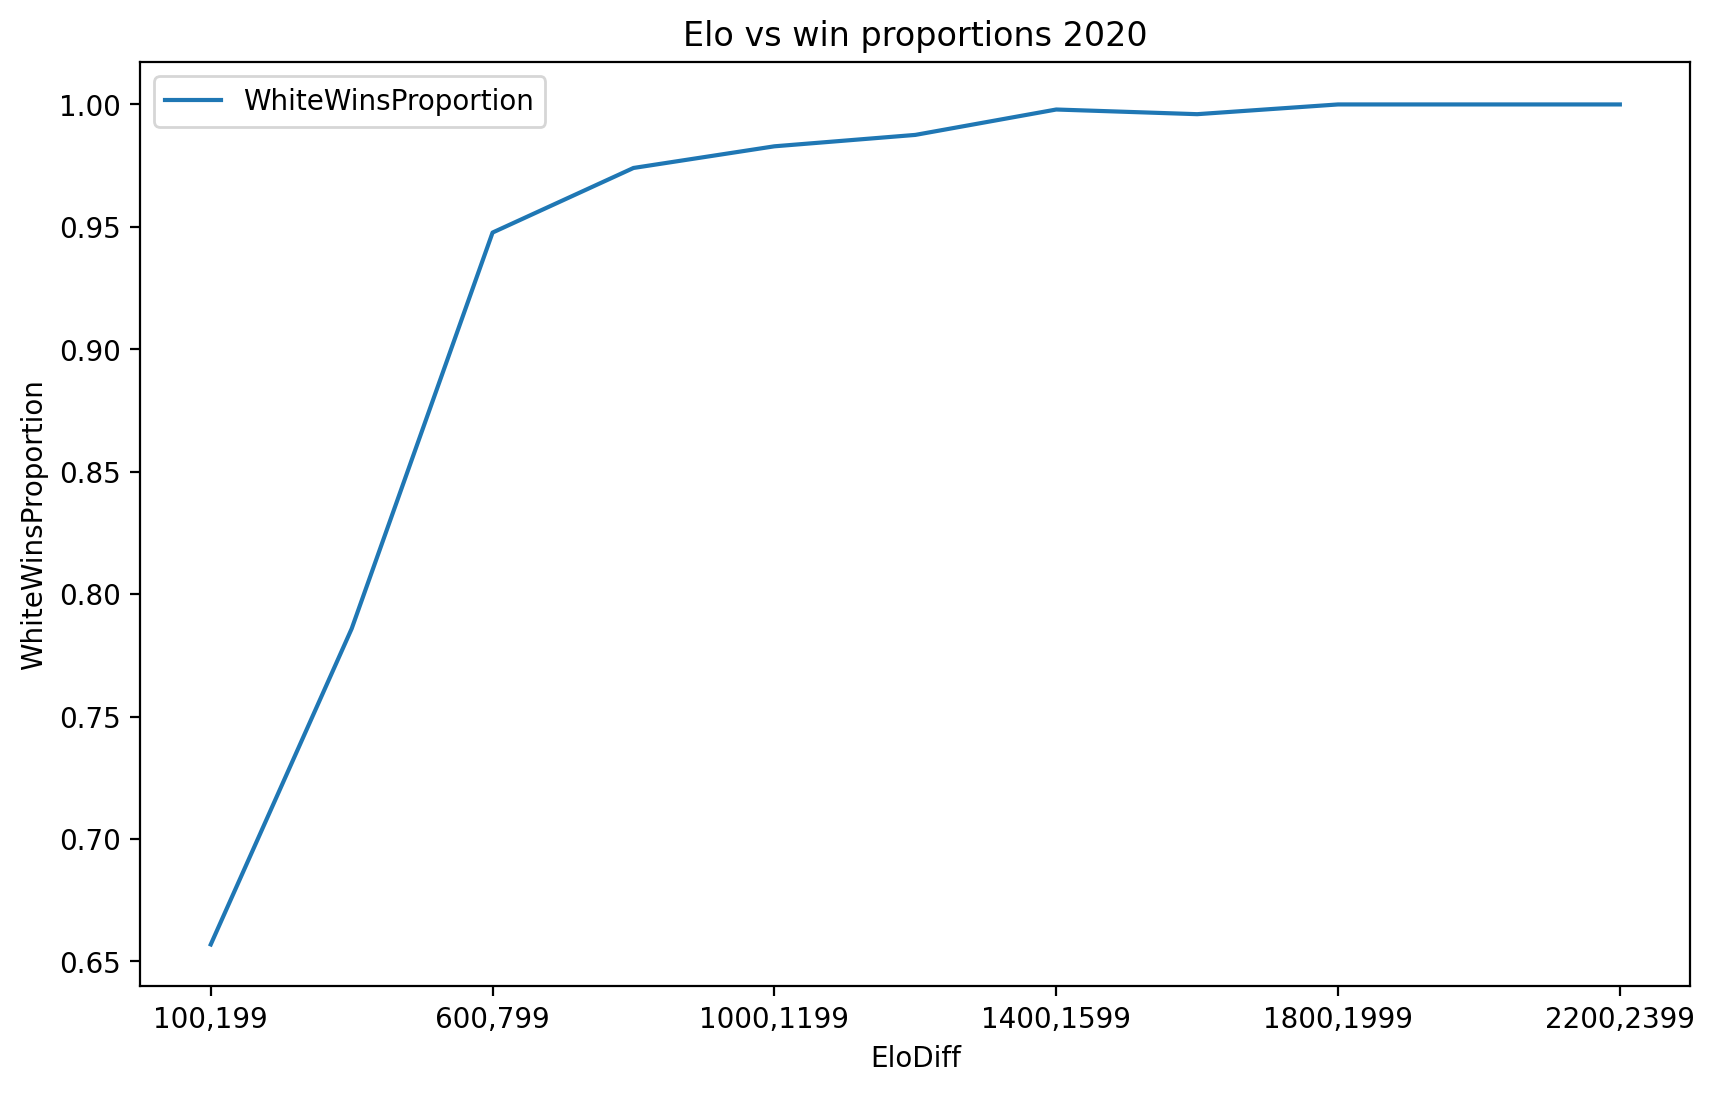

In [16]:
for year in range(FICS_MIN_YEAR,FICS_MAX_YEAR+1):
    frames=[win_rate_by_elo_diff_range(df[df["Year"]==str(year)],diff[0],diff[1]) for diff in ELO_GROUPS.values()]
    frames_df=pd.concat(frames)
    print("-"*50,"Player ratio for year",year,"-"*50)
    display(frames_df)
    ax= frames_df.plot.line(x='EloDiff', y='WhiteWinsProportion')

    ax.set_xlabel("EloDiff")
    ax.set_ylabel("WhiteWinsProportion")
    ax.set_title(f"Elo vs win proportions {year}")

    ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-vs-win-proportions-{year}.png")

### Winning distribtion

In [17]:
win_freq2=Counter(df[df["EloDiff"] > 20]["Result"])
white_won2=win_freq2["1-0"]
draw2=win_freq2["1/2-1/2"]
black_won2=win_freq2["0-1"]
total2=white_won2+draw2+black_won2
white_wins_proportion2 = white_won2 / total2
white_loss_proportion2 = black_won2 / total2
draw_proportion2 = draw2 / total2
print(
    f"Out of {total2} games:\n  White won {white_won2} games "
    f"({white_wins_proportion2:.2%}).\n  White lost {black_won2} games "
    f"({white_loss_proportion2:.2%}).\n"
    f"  White draw {draw2} games ({draw_proportion2:.2%}).  "
)

Out of 6377852 games:
  White won 4130191 games (64.76%).
  White lost 2011232 games (31.53%).
  White draw 236429 games (3.71%).  


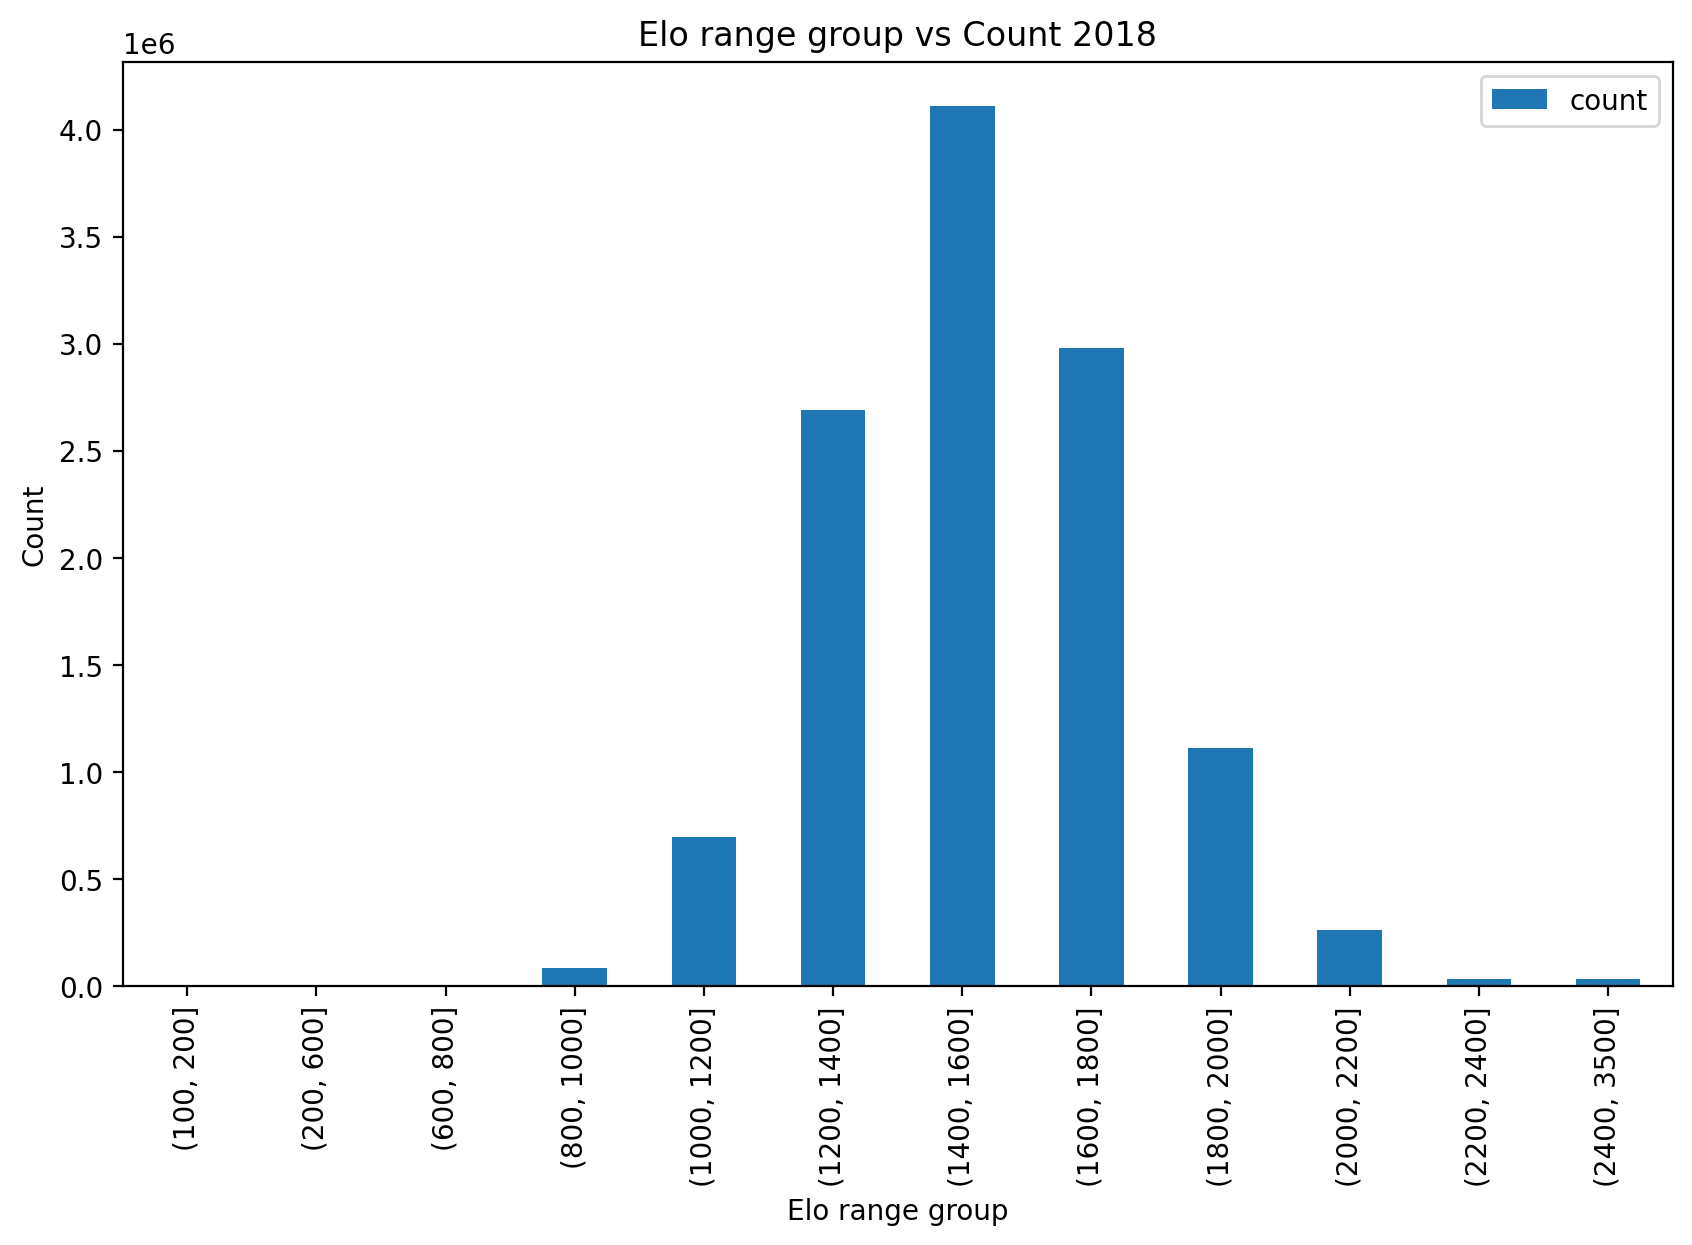

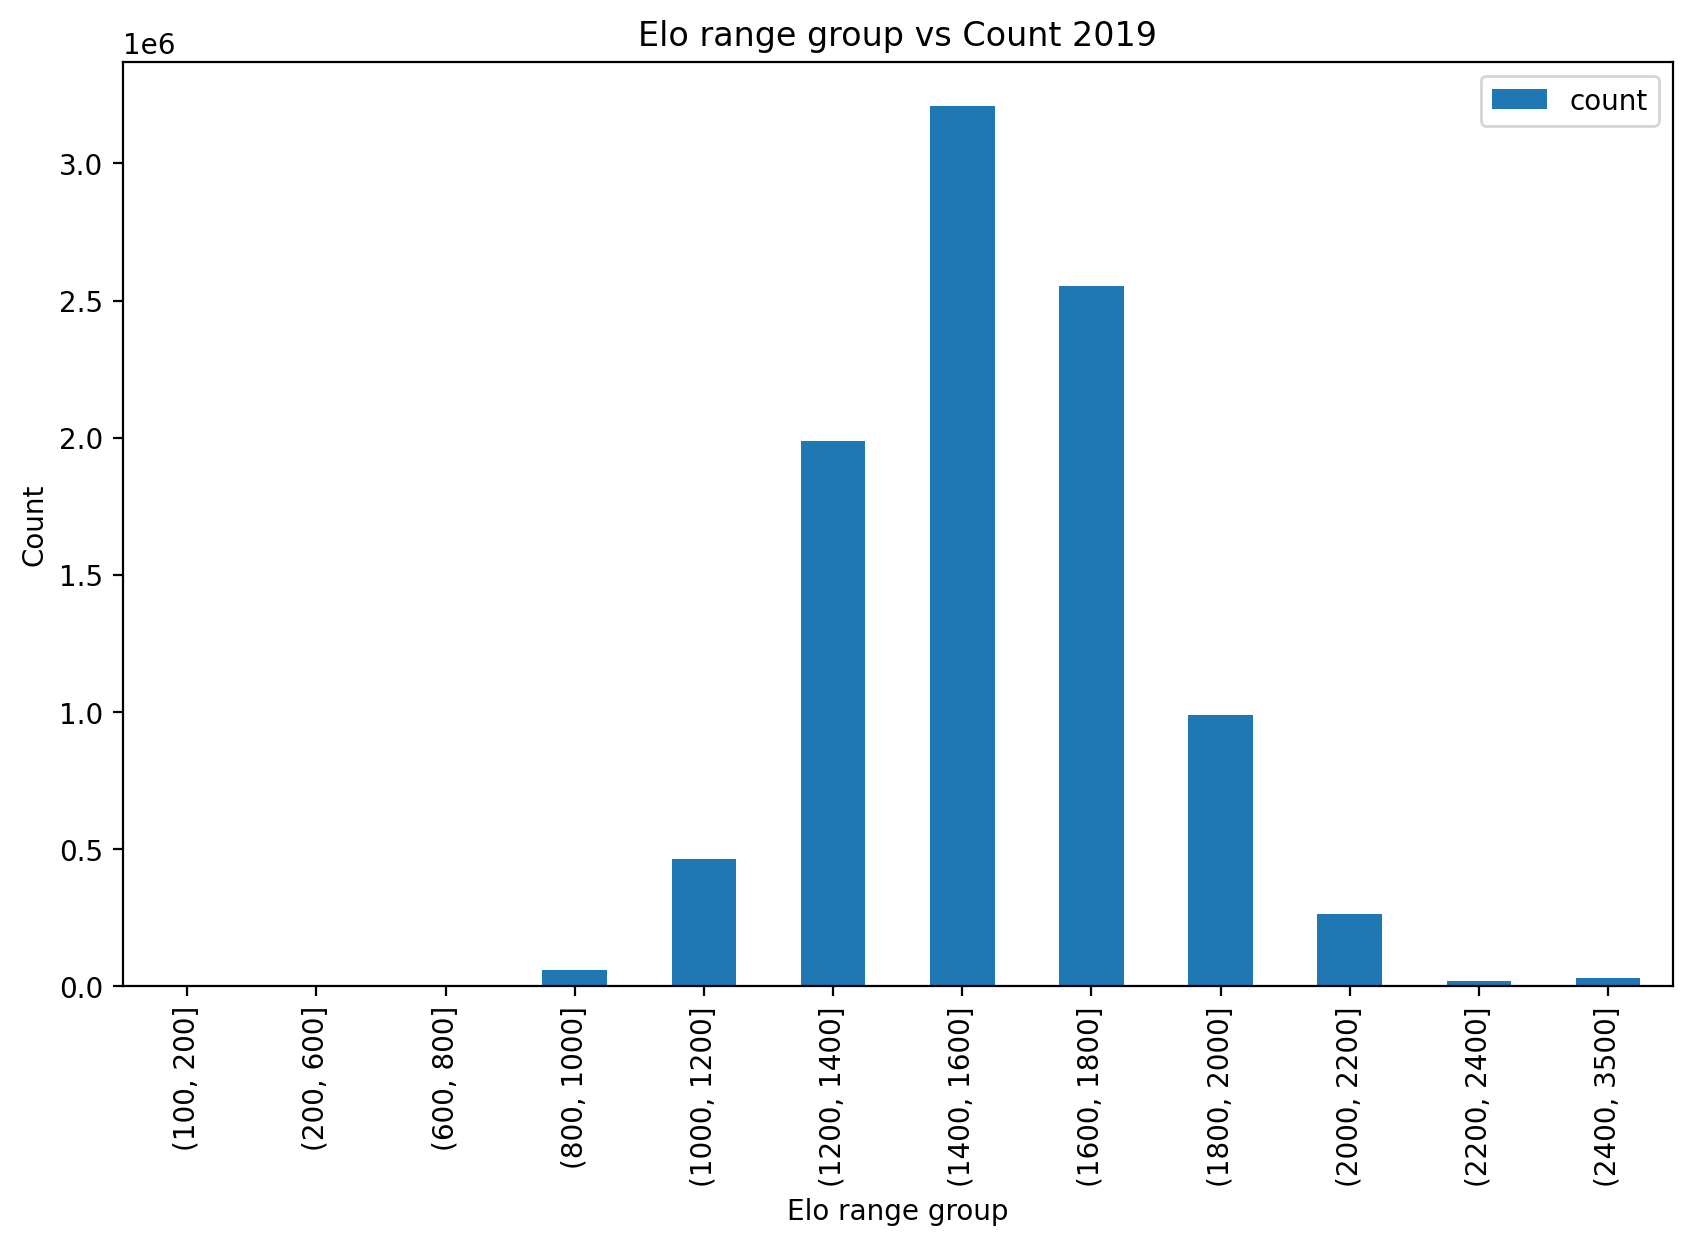

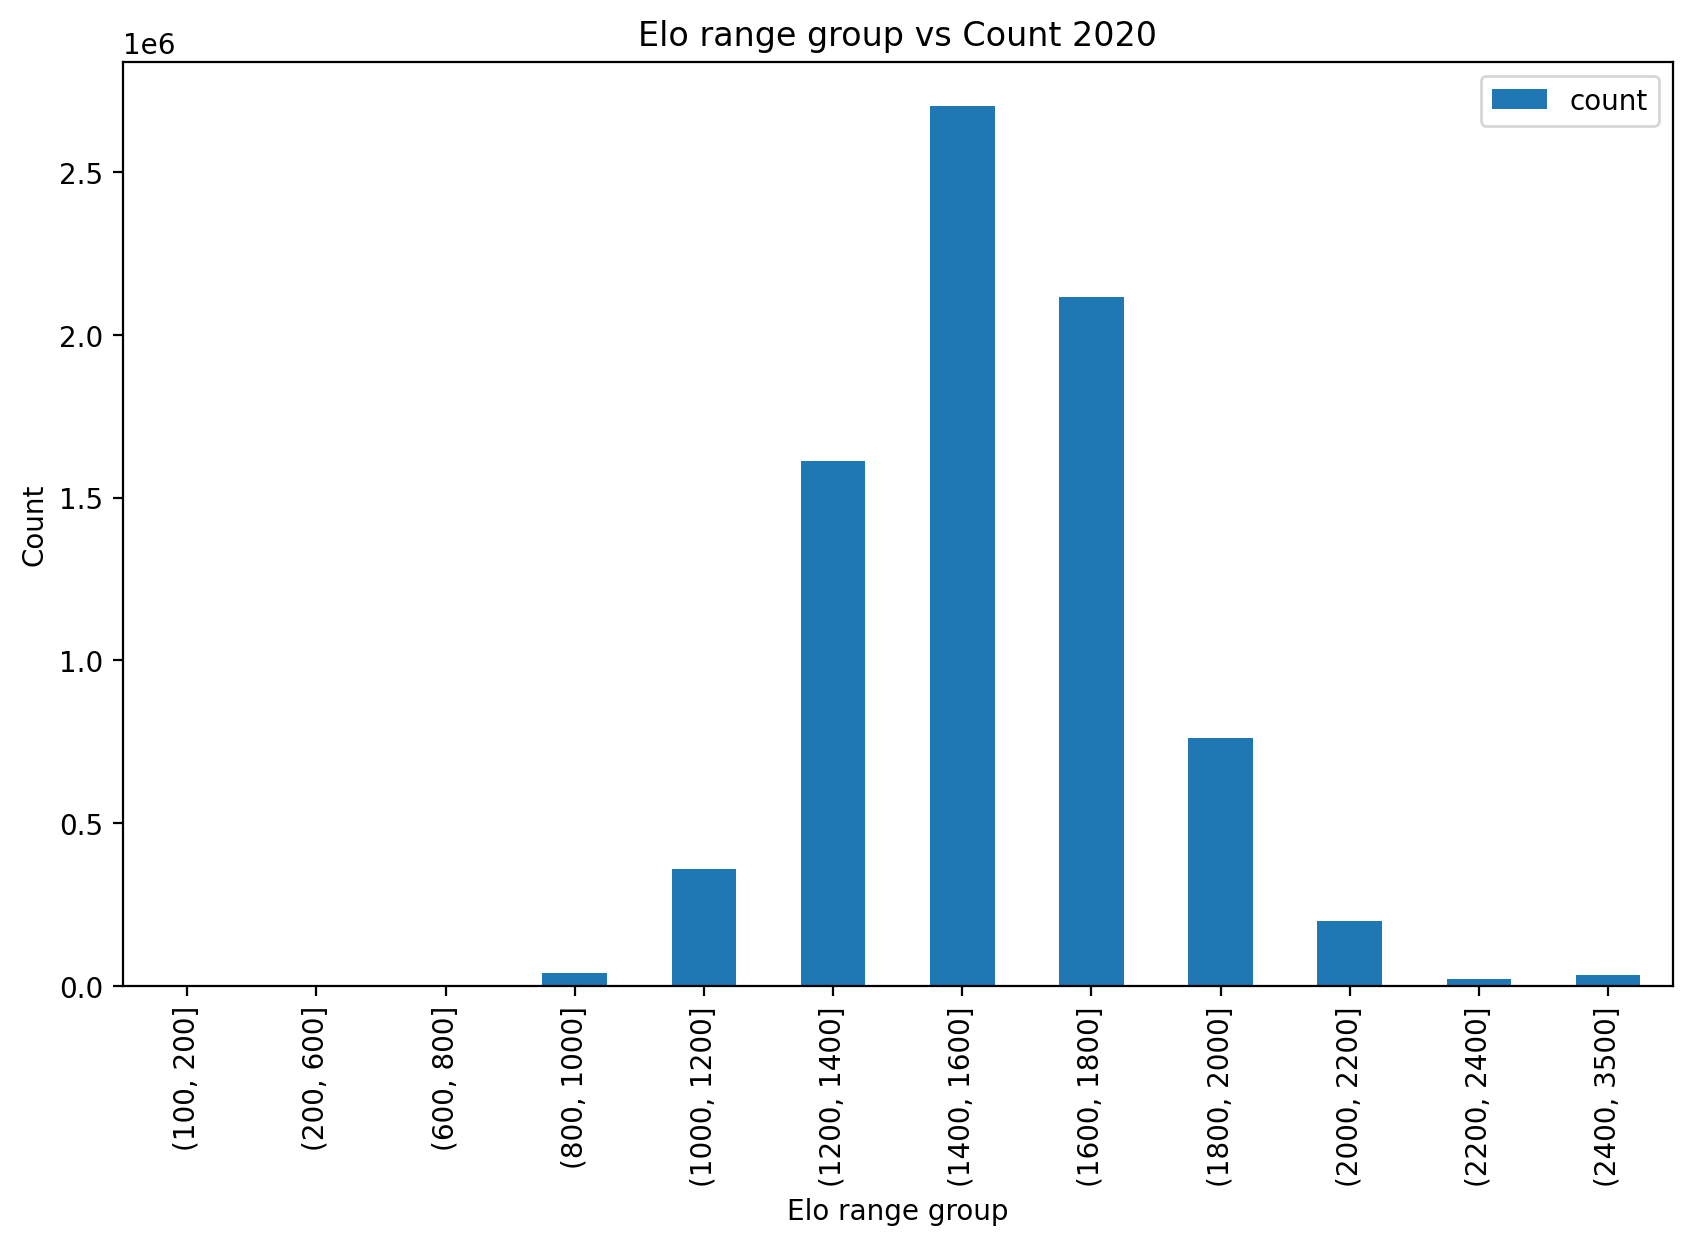

In [18]:
for year in range(FICS_MIN_YEAR,FICS_MAX_YEAR+1):
    elo_freq=get_elo_freq(df[df["Year"]==str(year)])
    elo_freq=elo_freq[["Elo","Count"]]
    rating_bins = [v[0] for v in list(ELO_GROUPS.values())]+[3500]
    cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
    elo_freq["group"]=cuts
    groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
    elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
    ax=elo_freq.plot(kind='bar',x='group',y='count')
    ax.set_title(f"Elo range group vs count for {year}")
    ax.set_xlabel("Elo range group")
    ax.set_ylabel("Count")
    ax.set_title(f"Elo range group vs Count {year}")
    ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-{year}.png")

### Elo differnce exploration

In [19]:
df["EloDiff"].describe()

count    1.471786e+07
mean    -1.877077e-01
std      1.915478e+02
min     -2.347000e+03
25%     -8.900000e+01
50%      0.000000e+00
75%      8.900000e+01
max      2.347000e+03
Name: EloDiff, dtype: float64

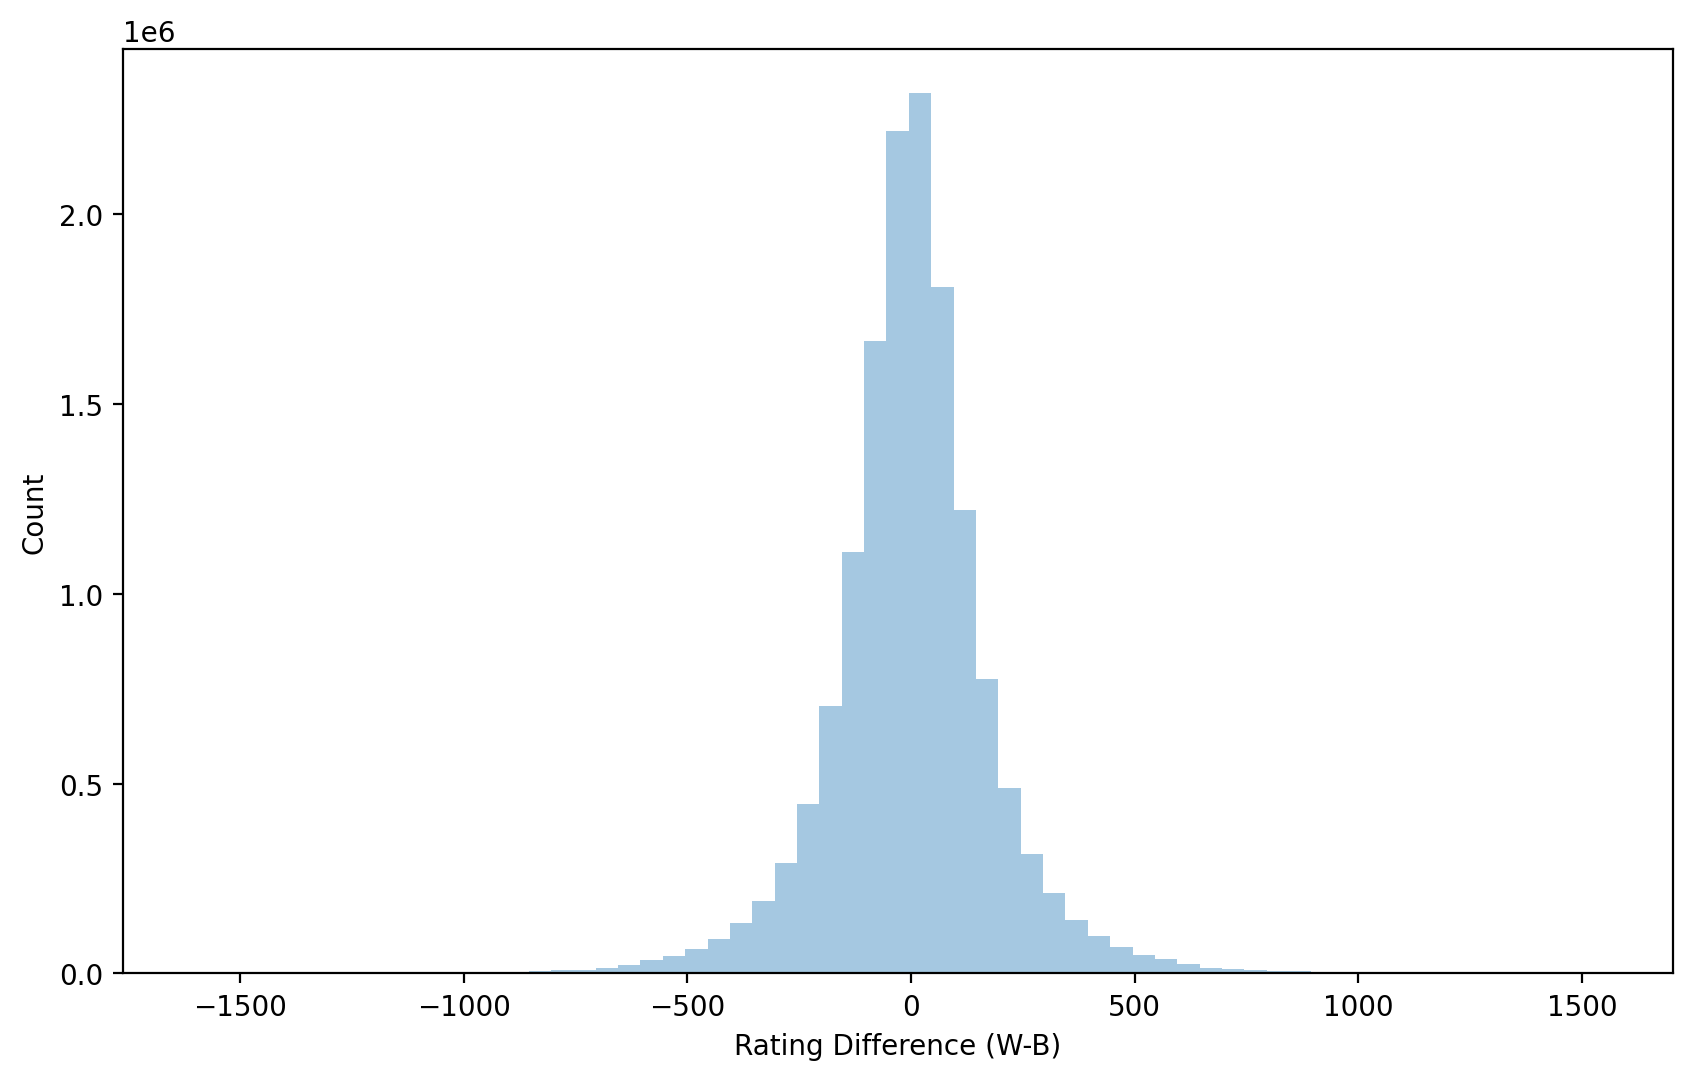

In [20]:
# bins
bins_diff = np.arange(-1605, 1499+50, 50)

# plot
sb.distplot(df["EloDiff"],kde=False, bins= bins_diff);
plt.xlabel('Rating Difference (W-B)');
plt.ylabel('Count');

ifference in rating forms a long tailed distribution at both ends with a peak at ~=0 of  games that both players ratings are so close.

Points at far ends could be considered outliers. Despite knowing that it is possible that in certain games there are high difference in ratings between the two players, those points shall be investigated further.

In [21]:
# far points at the left end
left_end = -1000 # eyeballed
print('Number of far points at the left end= {}'.format(df[df['EloDiff']<=left_end].shape[0]))
df[df['EloDiff']<=left_end] 

Number of far points at the left end= 19886


,Event,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,WhiteRD,BlackRD,TimeControl,Date,Time,WhiteClock,BlackClock,ECO,PlyCount,Result,Move,Year,EloDiff,RelativeEloDiff
45,FICS rated blitz game,455505072,KravchenkoVG,Knightsmasher,1165,2335,36.8,51.4,180+0,2019.11.30,08:05:00,0:03:00.000,0:03:00.000,A00,0,0-1,{White forfeits by disconnection} 0-1,2019,-1170,-33.43
71,FICS rated blitz game,455505043,KravchenkoVG,Knightsmasher,1165,2335,36.8,51.4,180+0,2019.11.30,07:59:00,0:03:00.000,0:03:00.000,D00,32,0-1,| d4 Nf6 | Bg5 d5 | e3 e6 | c4 Bb4+ | Nc3 O-O ...,2019,-1170,-33.43
2102,FICS rated blitz game,455502487,Thempo,Knightsmasher,1058,2335,133.1,51.5,180+0,2019.11.30,02:59:00,0:03:00.000,0:03:00.000,C23,58,0-1,| e4 e5 | Bc4 c6 | d3 d5 | exd5 cxd5 | Bb3 Nf6...,2019,-1277,-37.64
2228,FICS rated blitz game,455502300,naraindra,forlat,1036,2054,29.7,18.7,180+0,2019.11.30,02:26:00,0:03:00.000,0:03:00.000,C23,64,0-1,| e4 e5 | Bc4 d6 | Bxf7+ Kxf7 | Qh5+ g6 | Qf3+...,2019,-1018,-32.94
2263,FICS rated blitz game,455502256,naraindra,AnderssenA,1036,2406,29.7,36.3,300+0,2019.11.30,02:26:00,0:05:00.000,0:05:00.000,A00,0,0-1,{White forfeits by disconnection} 0-1,2019,-1370,-39.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14714519,FICS rated blitz game,434849778,Pranshu,exeComp,1428,2697,104.4,37.3,120+12,2018.08.09,15:52:00,0:02:00.000,0:02:00.000,C24,29,0-1,| e4 e5 | Bc4 Nf6 | Qf3 c6 | Nc3 b5 | Bb3 b4 |...,2018,-1269,-30.76
14715540,FICS rated blitz game,434848465,MolodoyVlad,ViceEngine,990,2092,82.4,54.0,300+2,2018.08.09,14:53:00,0:05:00.000,0:05:00.000,A05,5,0-1,| Nf3 Nf6 | g3 g6 | d3 {White forfeits by disc...,2018,-1102,-35.76
14716222,FICS rated blitz game,434847565,opu,PigeonEngine,1013,2039,82.3,45.9,120+6,2018.08.09,14:03:00,0:02:00.000,0:02:00.000,B10,30,0-1,| e4 c6 | b3 Nf6 | Nc3 e5 | Nf3 Bd6 | Ng5 O-O ...,2018,-1026,-33.62
14716352,FICS rated blitz game,434847407,opu,PigeonEngine,1013,2039,82.3,45.9,120+6,2018.08.09,13:55:00,0:02:00.000,0:02:00.000,B20,40,0-1,| e4 c5 | Bc4 Nc6 | Qh5 e6 | e5 g6 | Qe2 Nd4 |...,2018,-1026,-33.62


In [22]:
# far points at the right end
right_end= 1000 # eyeballed
print('Number of far points at the left end= {}'.format(df[df['EloDiff']>=right_end].shape[0]))
df[df['EloDiff']>=right_end] 

Number of far points at the left end= 19665


,Event,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,WhiteRD,BlackRD,TimeControl,Date,Time,WhiteClock,BlackClock,ECO,PlyCount,Result,Move,Year,EloDiff,RelativeEloDiff
48,FICS rated blitz game,455505068,Knightsmasher,KravchenkoVG,2335,1165,51.4,36.8,180+0,2019.11.30,08:03:00,0:03:00.000,0:03:00.000,C25,23,1-0,| e4 e5 | Nc3 Bb4 | Nd5 Ba5 | Qg4 g6 | b4 Bb6 ...,2019,1170,33.43
2120,FICS rated blitz game,455502459,Knightsmasher,Thempo,2335,1058,51.5,133.1,180+0,2019.11.30,02:56:00,0:03:00.000,0:03:00.000,C25,45,1-0,| e4 e5 | Nc3 Bc5 | Nf3 d6 | Na4 Nd7 | Nxc5 Nx...,2019,1277,37.64
2752,FICS unrated blitz game,455501603,RoyJuarez,daddyace,1997,714,93.0,265.6,420+5,2019.11.30,00:12:00,0:07:00.000,0:07:00.000,B12,47,1-0,| e4 c6 | d4 d5 | e5 Nd7 | e6 fxe6 | Be2 g6 | ...,2019,1283,47.33
2918,FICS rated blitz game,455501401,forlat,lawrencegern,2027,791,18.7,137.7,180+0,2019.11.29,23:47:00,0:03:00.000,0:03:00.000,D02,35,1-0,| Nf3 e6 | d4 d5 | g3 Bd7 | Bg2 Nc6 | O-O Qe7 ...,2019,1236,43.86
2947,FICS rated blitz game,455501366,forlat,lawrencegern,2027,791,18.7,137.8,180+0,2019.11.29,23:39:00,0:03:00.000,0:03:00.000,A00,49,1-0,| c3 f6 | e3 e5 | Bd3 Be7 | Qh5+ g6 | Bxg6+ Kf...,2019,1236,43.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14714449,FICS rated blitz game,434849865,exeComp,Pranshu,2697,1428,37.3,104.4,120+12,2018.08.09,15:57:00,0:02:00.000,0:02:00.000,A35,39,1-0,| Nf3 Nf6 | c4 c5 | Nc3 Nc6 | d4 d5 | cxd5 cxd...,2018,1269,30.76
14714591,FICS rated blitz game,434849683,exeComp,Pranshu,2697,1428,37.3,104.4,120+12,2018.08.09,15:50:00,0:02:00.000,0:02:00.000,D31,19,1-0,| d4 d5 | c4 e6 | Nc3 Bb4 | Nf3 Bxc3+ | bxc3 c...,2018,1269,30.76
14716083,FICS rated blitz game,434847735,ViceEngine,opu,2092,1013,54.0,82.2,300+2,2018.08.09,14:08:00,0:05:00.000,0:05:00.000,A41,37,1-0,| d4 d6 | Nf3 f6 | e4 Bg4 | Nc3 e5 | Bb5+ c6 |...,2018,1079,34.75
14716286,FICS rated blitz game,434847487,PigeonEngine,opu,2039,1013,45.9,82.3,120+6,2018.08.09,13:59:00,0:02:00.000,0:02:00.000,C21,27,1-0,| e4 e5 | d4 exd4 | c3 dxc3 | Bc4 cxb2 | Bxb2 ...,2018,1026,33.62


There is nothing odd about those points, the ones with the higher ratings win in all of these games which makes sense, except the fact that they cause long tails in both sides of the difference distribution, so I decided to keep them.

### Player color vs winning rate

We will show the effect of the players color on the winning rate

It is known that white has a slight advantage on winning chance

In [23]:
def get_win_vs_color_df(df):
    result={
        "Name":[],
        "Count":[],
        "Percent":[],
    }

    freq=Counter(df["Result"])
    total=sum(list(freq.values()))

    #
    result["Name"].append("White")
    result["Count"].append(freq["1-0"])
    result["Percent"].append((freq["1-0"]/total)*100)
    
    #
    result["Name"].append("Black")
    result["Count"].append(freq["0-1"])
    result["Percent"].append((freq["0-1"]/total)*100)

    #    
    result["Name"].append("Tie")
    result["Count"].append(freq["1/2-1/2"])
    result["Percent"].append((freq["1/2-1/2"]/total)*100)
    
    return pd.DataFrame.from_dict(result)


In [24]:
win_df=get_win_vs_color_df(df)
print("Color vs winning")
display(win_df)

Color vs winning


,Name,Count,Percent
0,White,7281347,49.472865
1,Black,6870808,46.683472
2,Tie,565705,3.843663


### Opening move vs winning rate

In [25]:
import requests

def get_first_moves_codes():

    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:122.0) Gecko/20100101 Firefox/122.0',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'Referer': 'https://www.google.com/',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
        'Sec-Fetch-Dest': 'document',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-Site': 'cross-site',
        'TE': 'trailers',
        'If-Modified-Since': 'Sat, 06 Apr 2024 00:01:03 GMT',
        'If-None-Match': '"1c54d-6156244ab188a-gzip"',
    }

    response = requests.get('https://www.chessgames.com/chessecohelp.html', headers=headers)
    moves_dict={}
    for line in response.text.split("\n"):
        if "<tr" not in line:
            continue

        code=line.split("face='arial,helvetica'>")[1].split("</font>")[0]
        description=line.split("face='arial,helvetica'>")[2].replace("<B>","").replace("</B><br>","")
        moves_dict[code]=description
    return moves_dict


In [26]:

def get_eco_freq_df(df):
    # get all codes
    moves_dict=get_first_moves_codes()
    eco_freq_dict={
        "Code":[],
        "Description":[],
        "WhiteWon":[],
        "WhiteWonPercent":[],
        "BlackWon":[],
        "BlackWonPercent":[],

        "Tie":[],
        "TiePercent":[],
        "Total":[],
    }

    # 
    freq=Counter(df["Result"])
    total=sum(list(freq.values()))

    eco_when_white_won=Counter(df[df["Result"]=="0-1"]["ECO"])
    eco_when_black_won=Counter(df[df["Result"]=="1-0"]["ECO"])
    eco_when_tie=Counter(df[df["Result"]=="1/2-1/2"]["ECO"])
    eco_sum={k:0 for k in moves_dict.keys()}

    # add cases when white won
    for k,v in eco_when_white_won.items():
        eco_sum[k]=eco_sum[k]+v

    # add cases when black won
    for k,v in eco_when_black_won.items():
        eco_sum[k]=eco_sum[k]+v

    # add cases when tie
    for k,v in eco_when_tie.items():
        eco_sum[k]=eco_sum[k]+v

    for k,v in moves_dict.items():
        WhiteWon=eco_when_white_won.get(k,0)
        BlackWon=eco_when_black_won.get(k,0)
        Tie=eco_when_tie.get(k,0)
        total=WhiteWon+BlackWon+Tie
        description=moves_dict[k]
        eco_freq_dict["Code"].append(k)
        eco_freq_dict["Description"].append(description)
        eco_freq_dict["WhiteWon"].append(WhiteWon)
        eco_freq_dict["WhiteWonPercent"].append((WhiteWon/total)*100)
        eco_freq_dict["BlackWon"].append(BlackWon)
        eco_freq_dict["BlackWonPercent"].append((BlackWon/total)*100)
        eco_freq_dict["Tie"].append(Tie)
        eco_freq_dict["TiePercent"].append((Tie/total)*100)
        eco_freq_dict["Total"].append(total)
    return pd.DataFrame.from_dict(eco_freq_dict)


In [27]:
eco_freq_df=get_eco_freq_df(df)


print("The cases where white had advantage:")
display(eco_freq_df[eco_freq_df["WhiteWonPercent"]>50].sort_values(by="WhiteWonPercent",ascending=False)[["Code","WhiteWonPercent","WhiteWon","Total"]])

print("The cases where black had advantage:")
display(eco_freq_df[eco_freq_df["BlackWonPercent"]>50].sort_values(by="WhiteWonPercent",ascending=True)[["Code","BlackWonPercent","BlackWon","Total"]])


The cases where white had advantage:


,Code,WhiteWonPercent,WhiteWon,Total
445,E45,66.666667,28,42
426,E26,61.559140,229,372
496,E96,60.000000,3,5
428,E28,58.851675,123,209
204,C04,58.217822,294,505
...,...,...,...,...
170,B70,50.185912,4859,9682
140,B40,50.145219,55422,110523
85,A85,50.144209,17386,34672
116,B16,50.084926,2359,4710


The cases where black had advantage:


,Code,BlackWonPercent,BlackWon,Total
399,D99,80.000000,8,10
165,B65,62.765957,59,94
164,B64,65.254237,77,118
369,D69,51.898734,41,79
161,B61,65.771812,98,149
...,...,...,...,...
252,C52,50.695292,2078,4099
257,C57,50.248732,10202,20303
159,B59,50.151362,497,991
235,C35,50.380102,12923,25651


In [28]:
df['ECO'].nunique() # number of unique opening ECOs

500



There are 500 unique openings which makes them hard to investigate.

According to 365Chess, those openings are divided in five volumes labeled from "A" through "E". So, I will use those five volumes instead of the whole 500 openings.


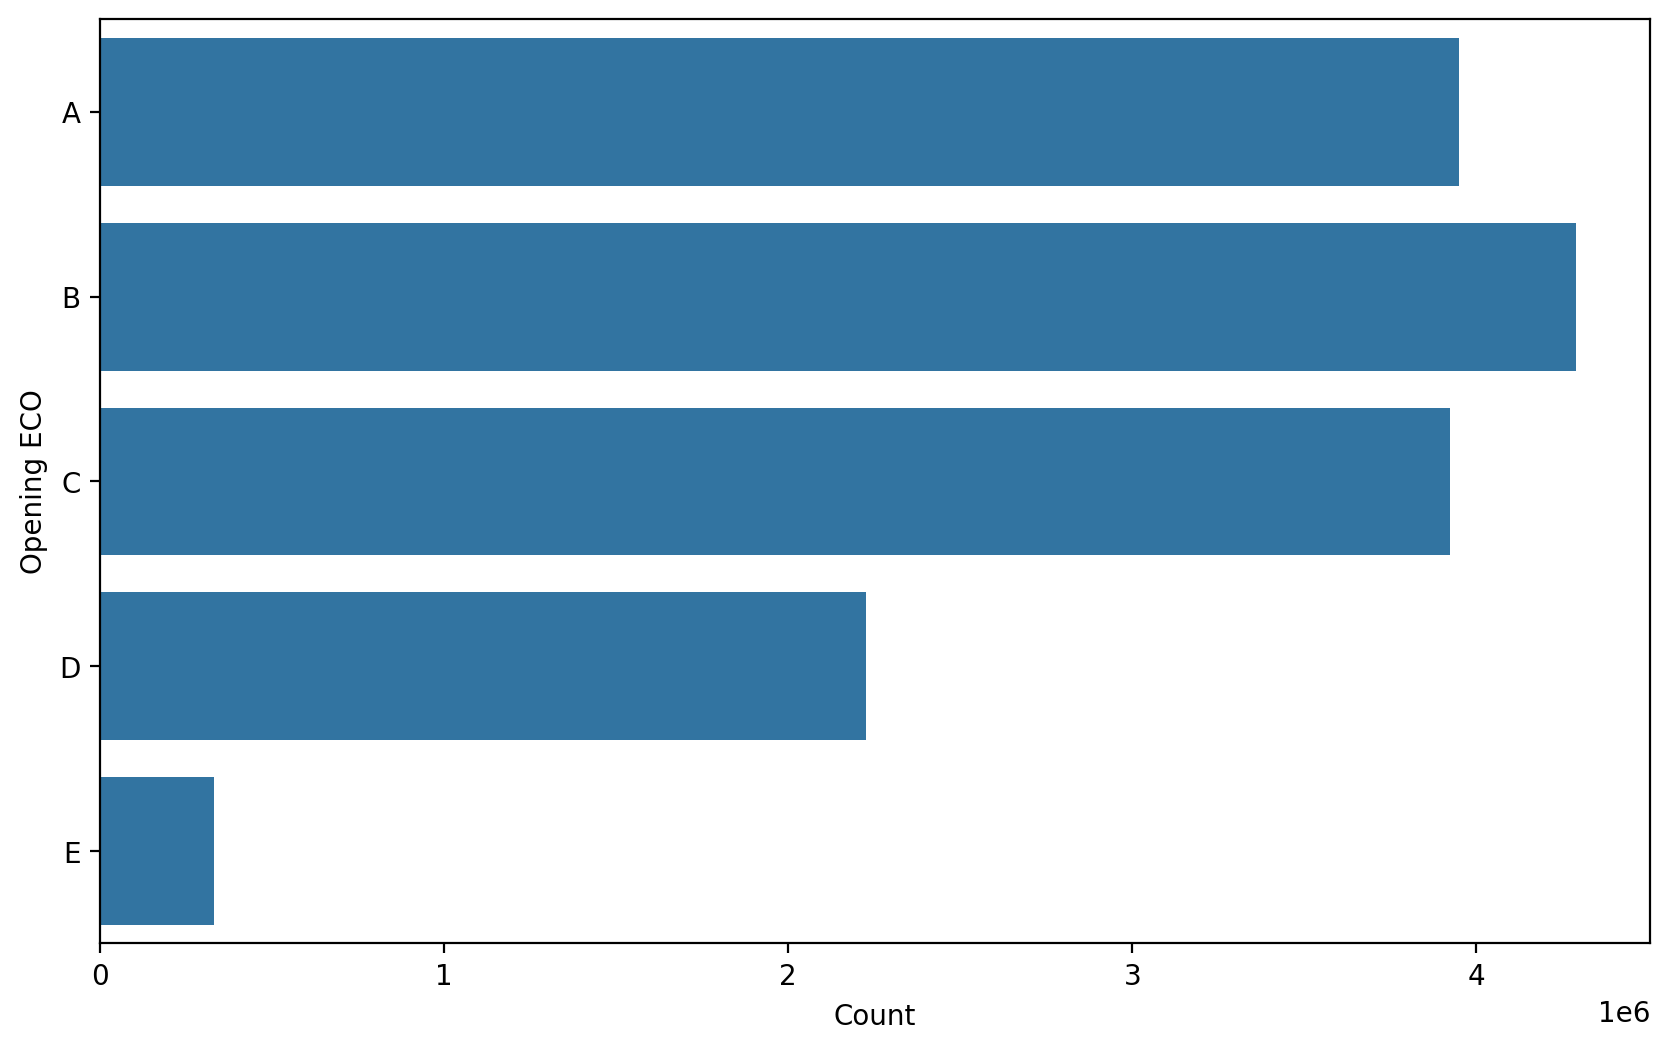

In [29]:
# keeping volume labels and remove the rest of the codes
df['ECO_class']= df['ECO'].apply(lambda x: x[0]) 

# converting opening_eco data type to ordered categorical data type (alphabetically)
openings = ['A', 'B', 'C', 'D', 'E']
openings_cat = pd.api.types.CategoricalDtype(categories= openings, ordered=True)
df['ECO_class'] = df['ECO_class'].astype(openings_cat)


# plot
sb.countplot(data=df, y= 'ECO_class', color= base_color);
plt.ylabel('Opening ECO');
plt.xlabel('Count');

Openings in volume B are the most frequent followed by A and C. Volume D occurs much less and volume E openings are rarely used.

## 4.2. Games investigation

In this section we will analysis game events

### Victory Status
We will analyse the differnet winning statuses

In [30]:
df["Winning status"]=df["Move"].apply(lambda r:r.split("|")[-1].split("{")[1].split("}")[0])
df["Winning status"].describe()

count          14717860
unique               20
top       Black resigns
freq            3392439
Name: Winning status, dtype: object

In [31]:
print(df['Winning status'].value_counts())

Winning status
Black resigns                                              3392439
White resigns                                              3187999
Black forfeits on time                                     1982493
White forfeits on time                                     1960776
Black checkmated                                           1596071
White checkmated                                           1419613
Black forfeits by disconnection                             306178
White forfeits by disconnection                             298987
Game drawn by repetition                                    169350
Neither player has mating material                           94606
Game drawn by mutual agreement                               82588
Black ran out of time and White has no material to mate      68594
White ran out of time and Black has no material to mate      67269
Game drawn by stalemate                                      62770
Game drawn because both players ran out of time

In [32]:
def simplify_status(status):
    if "resign" in status:
        return "resign"
    if "mate" in status:
        return "mate"
    if "outoftime" in status:
        return "outoftime"
    if "draw" in status:
        return "draw"
    if "win" in status:
        return "win"
    if "forfeit" in status:
        return "forfeit"
    return status

In [33]:
df["Winning status"]=df["Winning status"].apply(lambda s:simplify_status(s))


In [34]:
df["Winning status"].describe()

count     14717860
unique           5
top         resign
freq       6580438
Name: Winning status, dtype: object

In [35]:
print(df['Winning status'].value_counts())

Winning status
resign     6580438
forfeit    4548434
mate       3308923
draw        272466
win           7599
Name: count, dtype: int64


Winning status
resign     6580438
forfeit    4548434
mate       3308923
draw        272466
win           7599
Name: count, dtype: int64


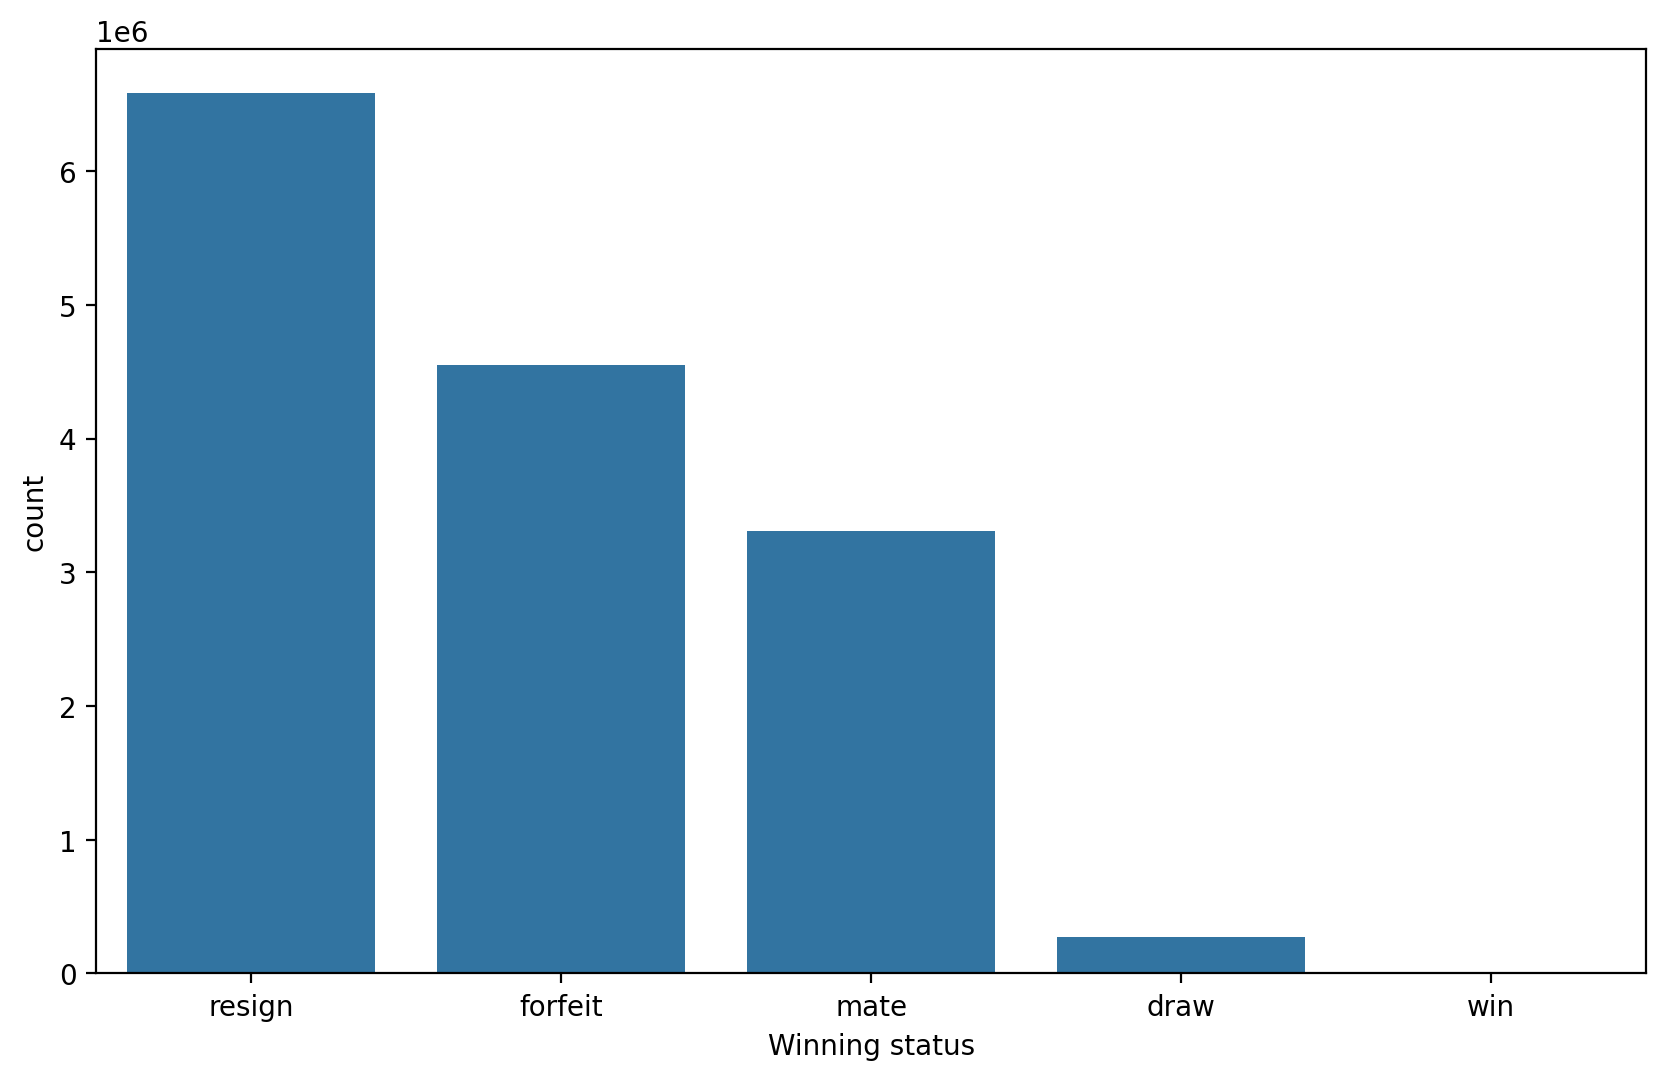

In [36]:
# distribution of game status in a bar chart
status_order = df['Winning status'].value_counts().index
sb.countplot(data=df, x='Winning status', color=base_color, order=status_order);
plt.xlabel('Winning status');
print(df['Winning status'].value_counts())

Resigning the game occurs the most, mate is the second most and much less occurances of out of time and draw games.

It is not unusual that most of the games end with one of the players resigning because they figure out when they lose before it actually happens by calculating next possible moves.

### Number of turns vs winning rate
We will study the effect of number of turns on the winning chance

In [37]:
df["PlyCount"].describe()

count    1.471786e+07
mean     7.093761e+01
std      3.138746e+01
min      0.000000e+00
25%      4.900000e+01
50%      6.800000e+01
75%      9.000000e+01
max      6.000000e+02
Name: PlyCount, dtype: float64

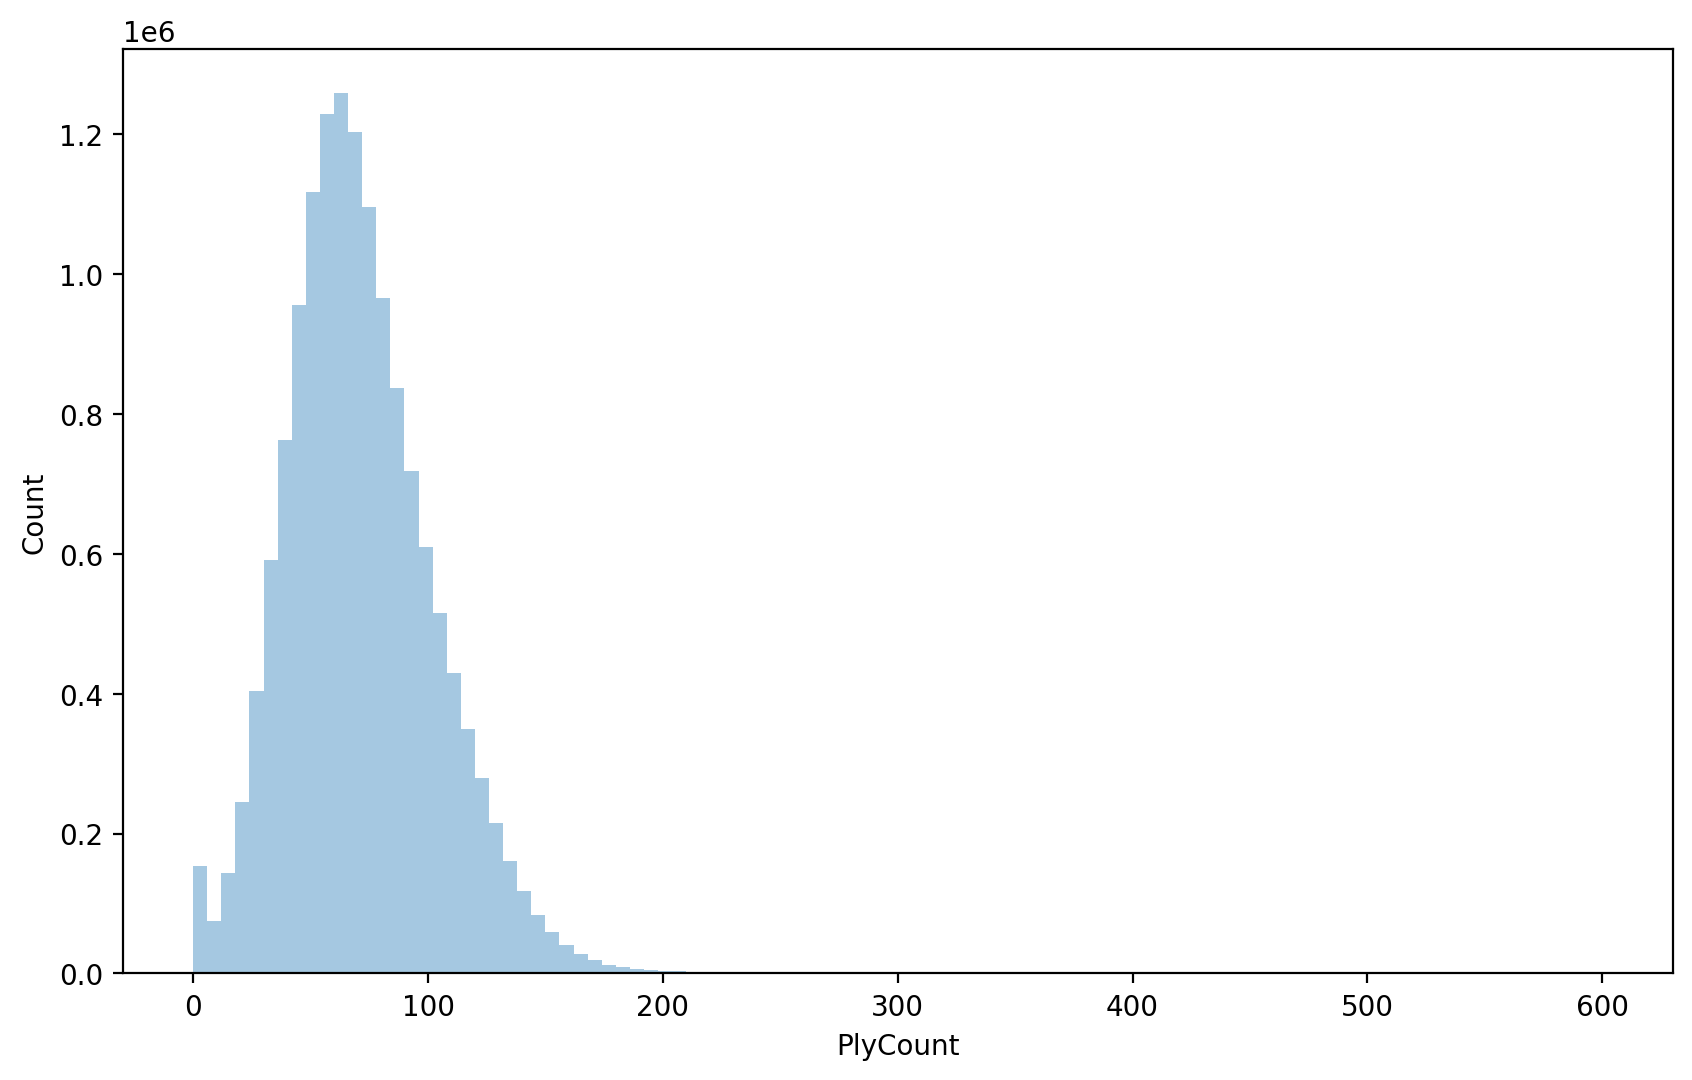

In [38]:
# bin edges
step= 6
bins_turns = np.arange(df['PlyCount'].min(), df['PlyCount'].max()+step, step)

# plot
sb.distplot(df['PlyCount'], kde=False, bins=bins_turns);
plt.xlabel('PlyCount')
plt.ylabel('Count');

The distribution of turns is right skewed with a long tail that suggests further investigation using log scale

In [39]:
np.log10(df['PlyCount'].describe())

count    7.167845
mean     1.850877
std      1.496756
min          -inf
25%      1.690196
50%      1.832509
75%      1.954243
max      2.778151
Name: PlyCount, dtype: float64

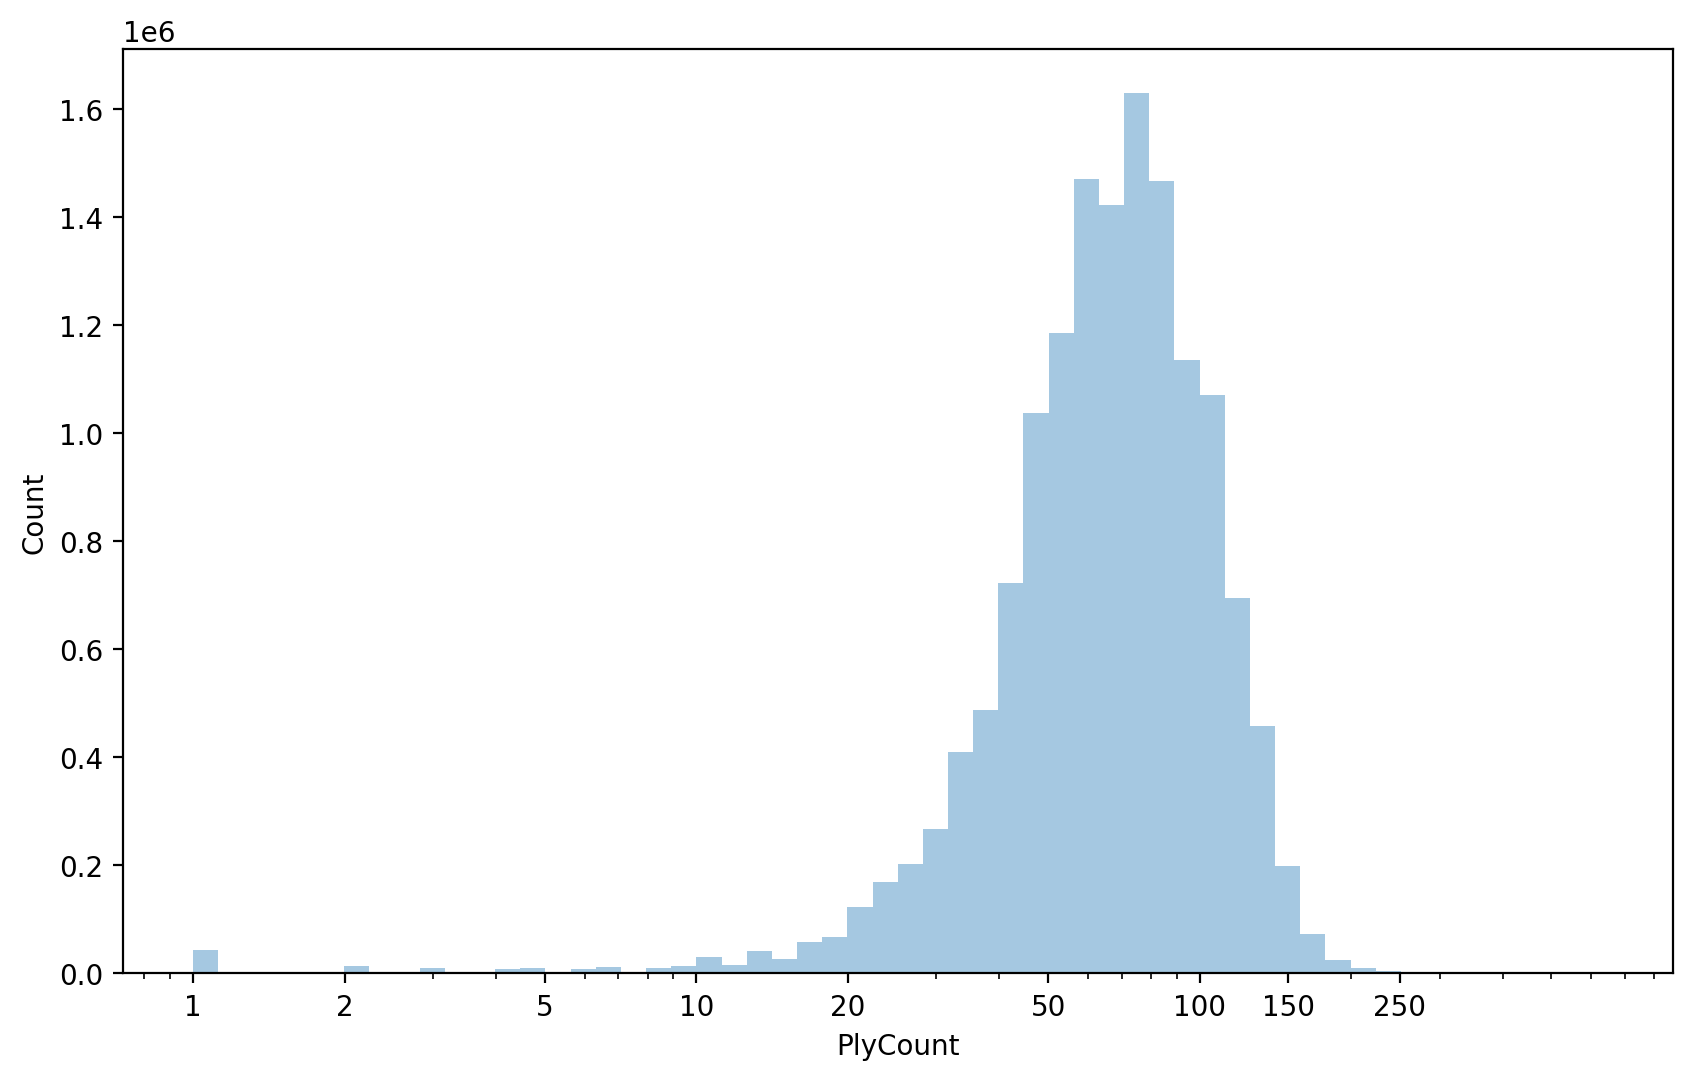

In [40]:
# right skewed distribution with long tail suggests plotting the distribution with a log scale 
step = 0.05
bins_log_turns = 10**np.arange(0,np.log10(df['PlyCount'].max())+step, step)
sb.distplot(df['PlyCount'], kde=False, bins= bins_log_turns);
plt.xscale('log')
ticks = [1, 2, 5, 10, 20, 50 ,100, 150, 250]
plt.xticks(ticks, ticks)
plt.xlabel('PlyCount')
plt.ylabel('Count');


The log scale exposes the obvious outliers at the left end which doesn't make sense in practice as it is hard for a game to be won by less than 4 turns. 

In [41]:
# investigating far points at the left
df["Winning status"]=df["Move"].apply(lambda r:r.split("|")[-1].split("{")[1].split("}")[0]).apply(lambda s:simplify_status(s))
print(df[(df['PlyCount']<4)].value_counts())

Event                    FICSGamesDBGameNo  White           Black              WhiteElo  BlackElo  WhiteRD  BlackRD  TimeControl  Date        Time      WhiteClock   BlackClock   ECO  PlyCount  Result  Move                                                 Year  EloDiff  RelativeEloDiff  ECO_class  Winning status
FICS rated blitz game    430003430          gogoedos        zadox              1453      1240      29.0     23.0     300+12       2018.01.01  00:13:00  0:05:00.000  0:05:00.000  D00  2         0-1     | d4 d5 {White forfeits on time} 0-1                 2018   213      7.91            D          forfeit           1
                         455282684          desertkiwi      jestrada           1403      1711      20.1     25.2     180+0        2019.11.15  01:31:00  0:03:00.000  0:03:00.000  A04  1         1-0     | Nf3 {Black forfeits by disconnection} 1-0          2019  -308     -9.89            A          forfeit           1
                         455283743          johnlorenz

There are 136095 games in which one of the players resigned, and it is nearly impossible for the game to be finished in just 3 turns. It should be noted that it is an online game and there are many reasons for a player to resign a game and those reasons may mostly be unrelated to the game itself specially with such small number of turns. So those games are to be dropped from the dataset.

In [42]:
df = df[(df['PlyCount']>=4)]

### Rating by game type

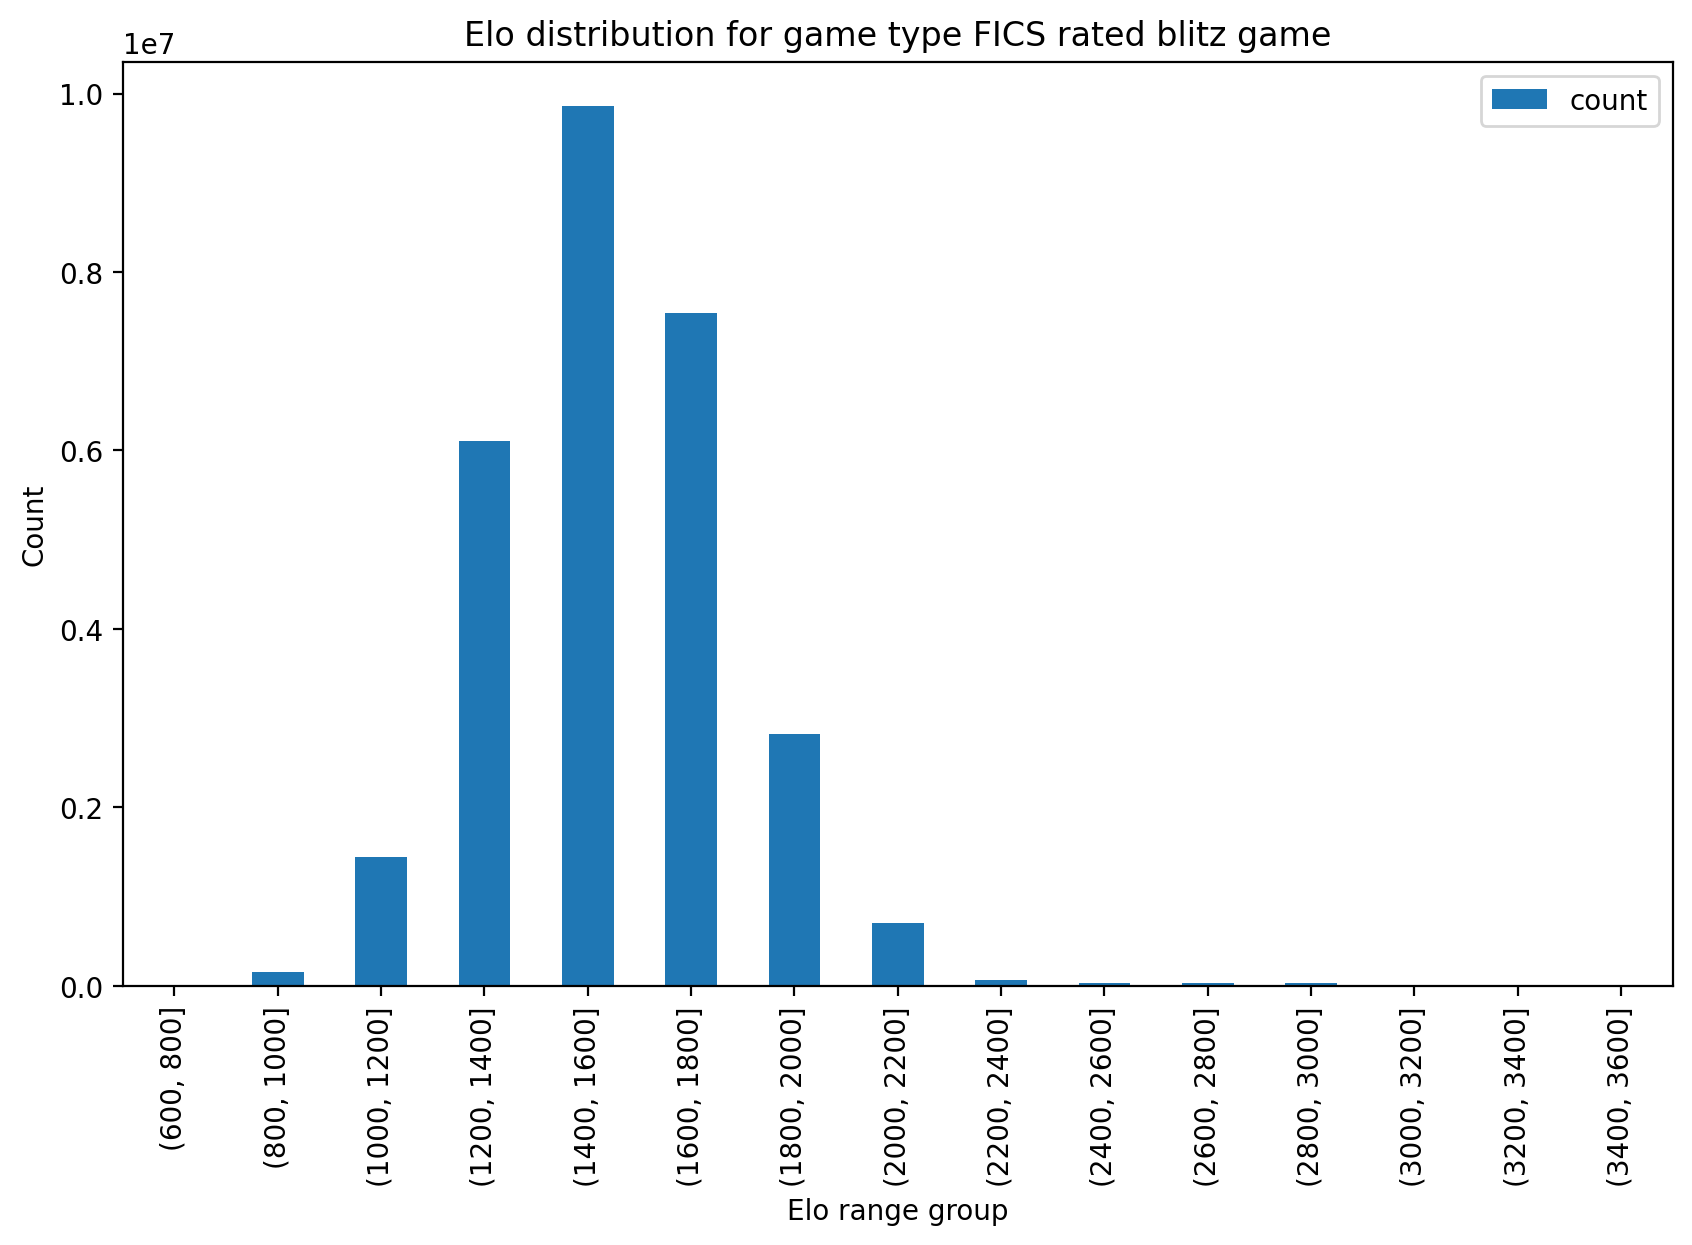

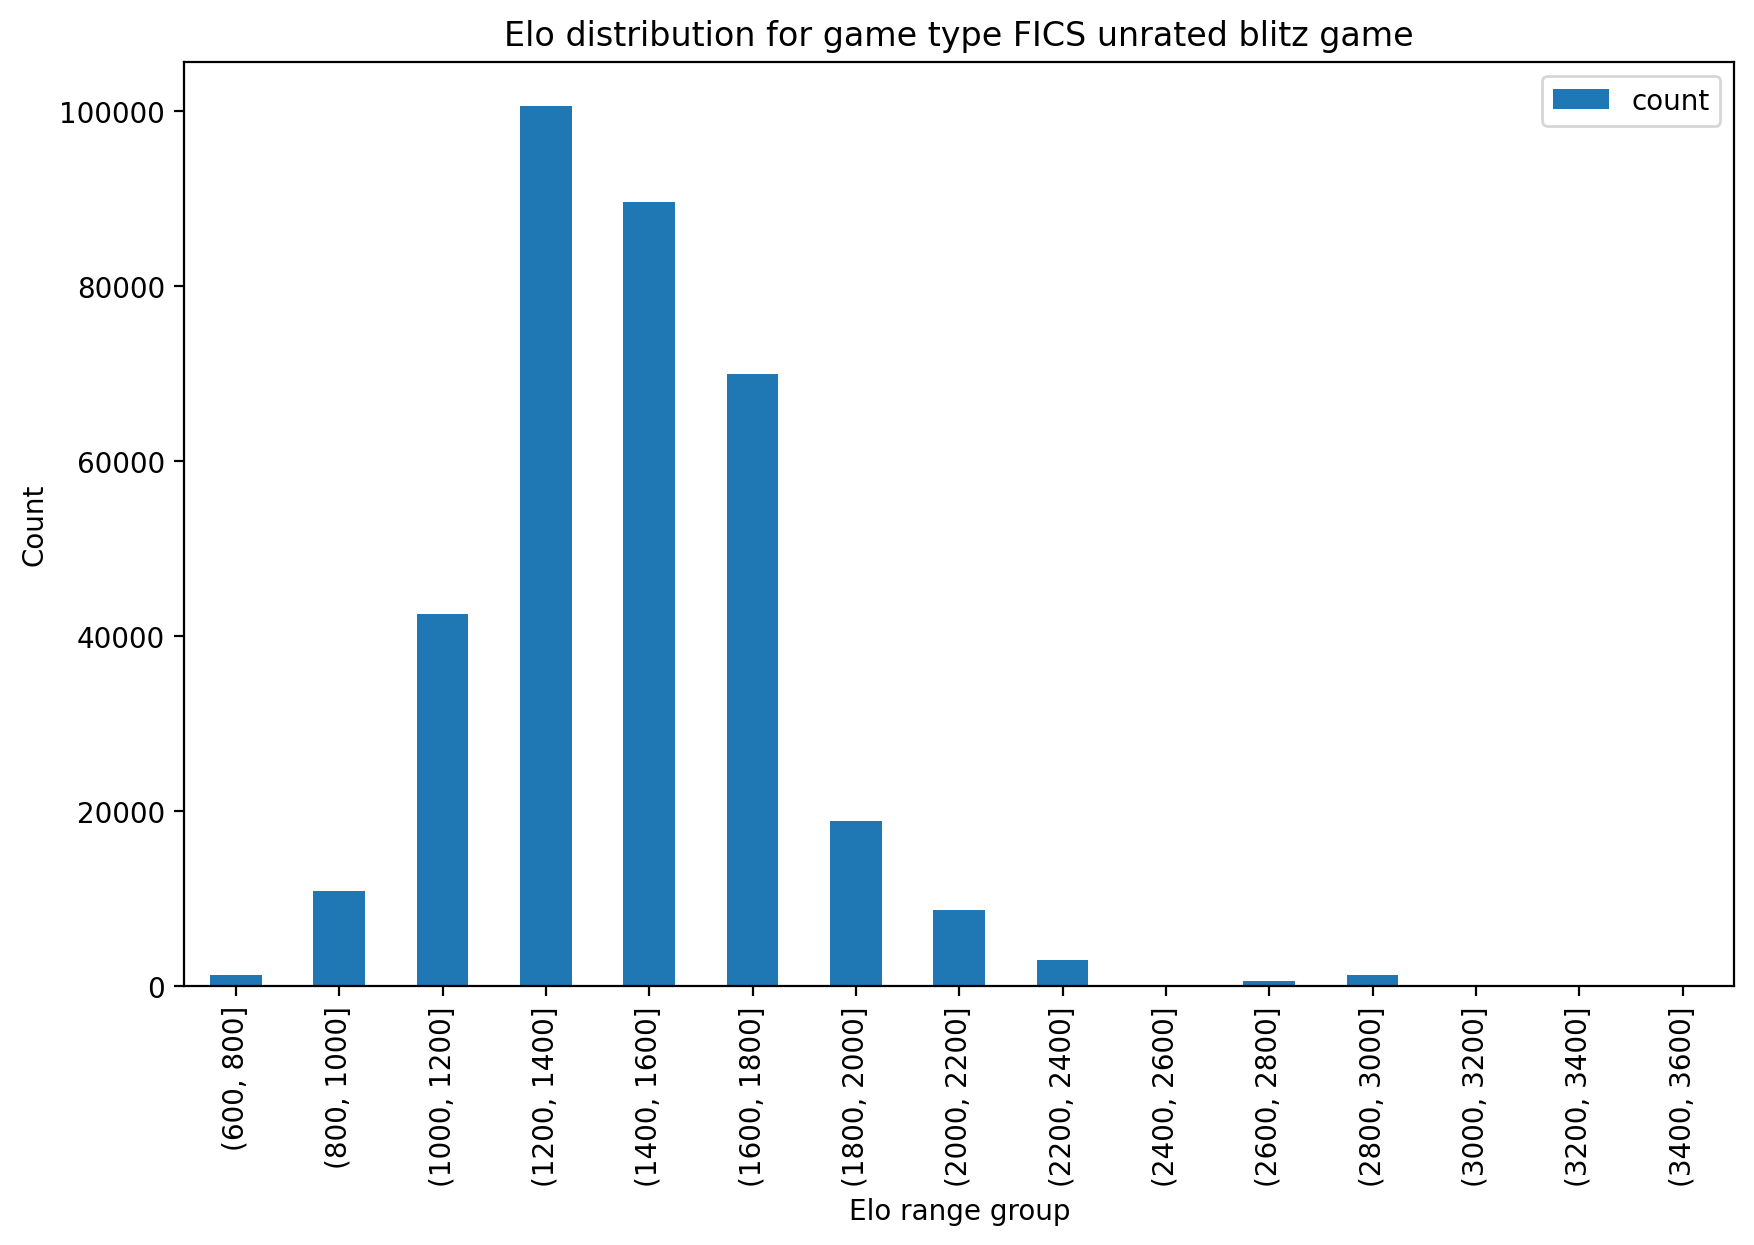

In [43]:
events=list(set(list(df["Event"])))


for e in events:
    df_e=df[df["Event"]==e]

    elo_freq=get_elo_freq(df_e)
    elo_freq=elo_freq[["Elo","Count"]]
    rating_bins = np.arange(600,3601, 200)
    cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
    elo_freq["group"]=cuts
    groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
    elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
    ax=elo_freq.plot(kind='bar',x='group',y='count')
    ax.set_xlabel("Elo range group")
    ax.set_ylabel("Count")
    ax.set_title(f"Elo distribution for game type {e}")
    ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-all-years-{e}.png")

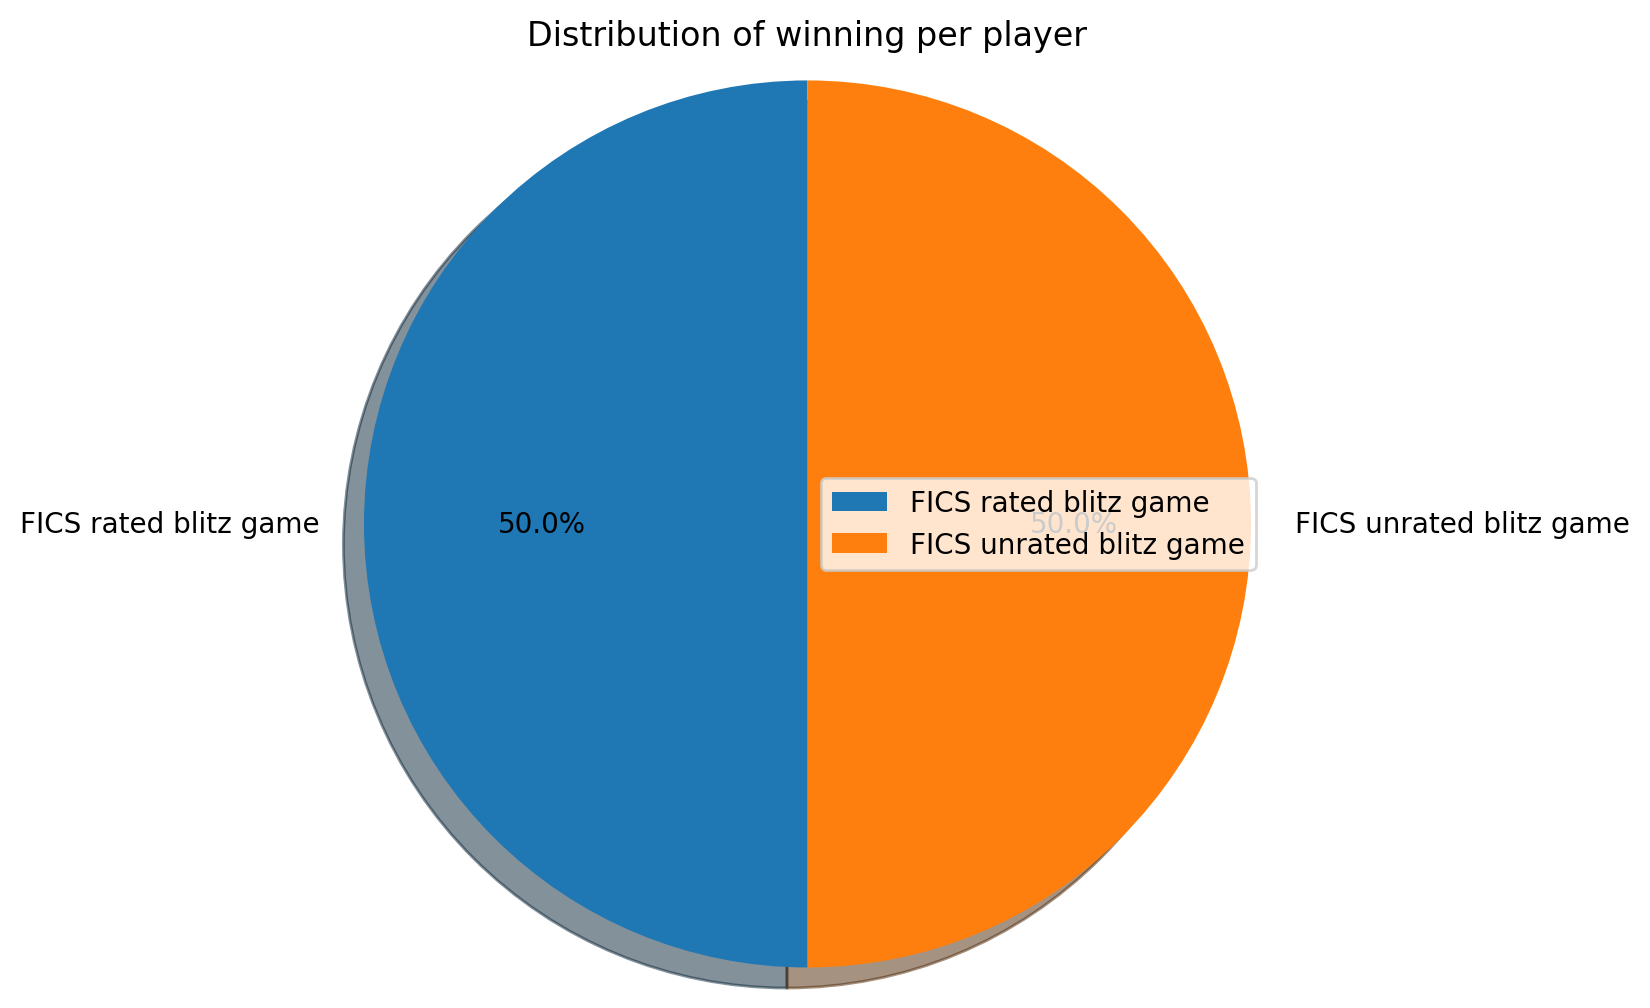

In [44]:
import matplotlib.pyplot as plt


by_event={e:len(df["Event"]==e) for e in list(set(list(df["Event"])))}
# defining labels
activities = list(by_event.keys())

# portion covered by each label
slices = list(by_event.values())

# color for each label
colors = ['r', 'y', 'g', 'b']

# plotting the pie chart
ax=plt.pie(slices, labels = activities,
        startangle=90, shadow = True,
        radius = 1.2, autopct = '%1.1f%%')

# plotting legend
plt.legend()
plt.title("Distribution of winning per player")


plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Distribution-of-winning-per-player-all-years-{e}.png")

# showing the plot
plt.show()


### Number of games distributions

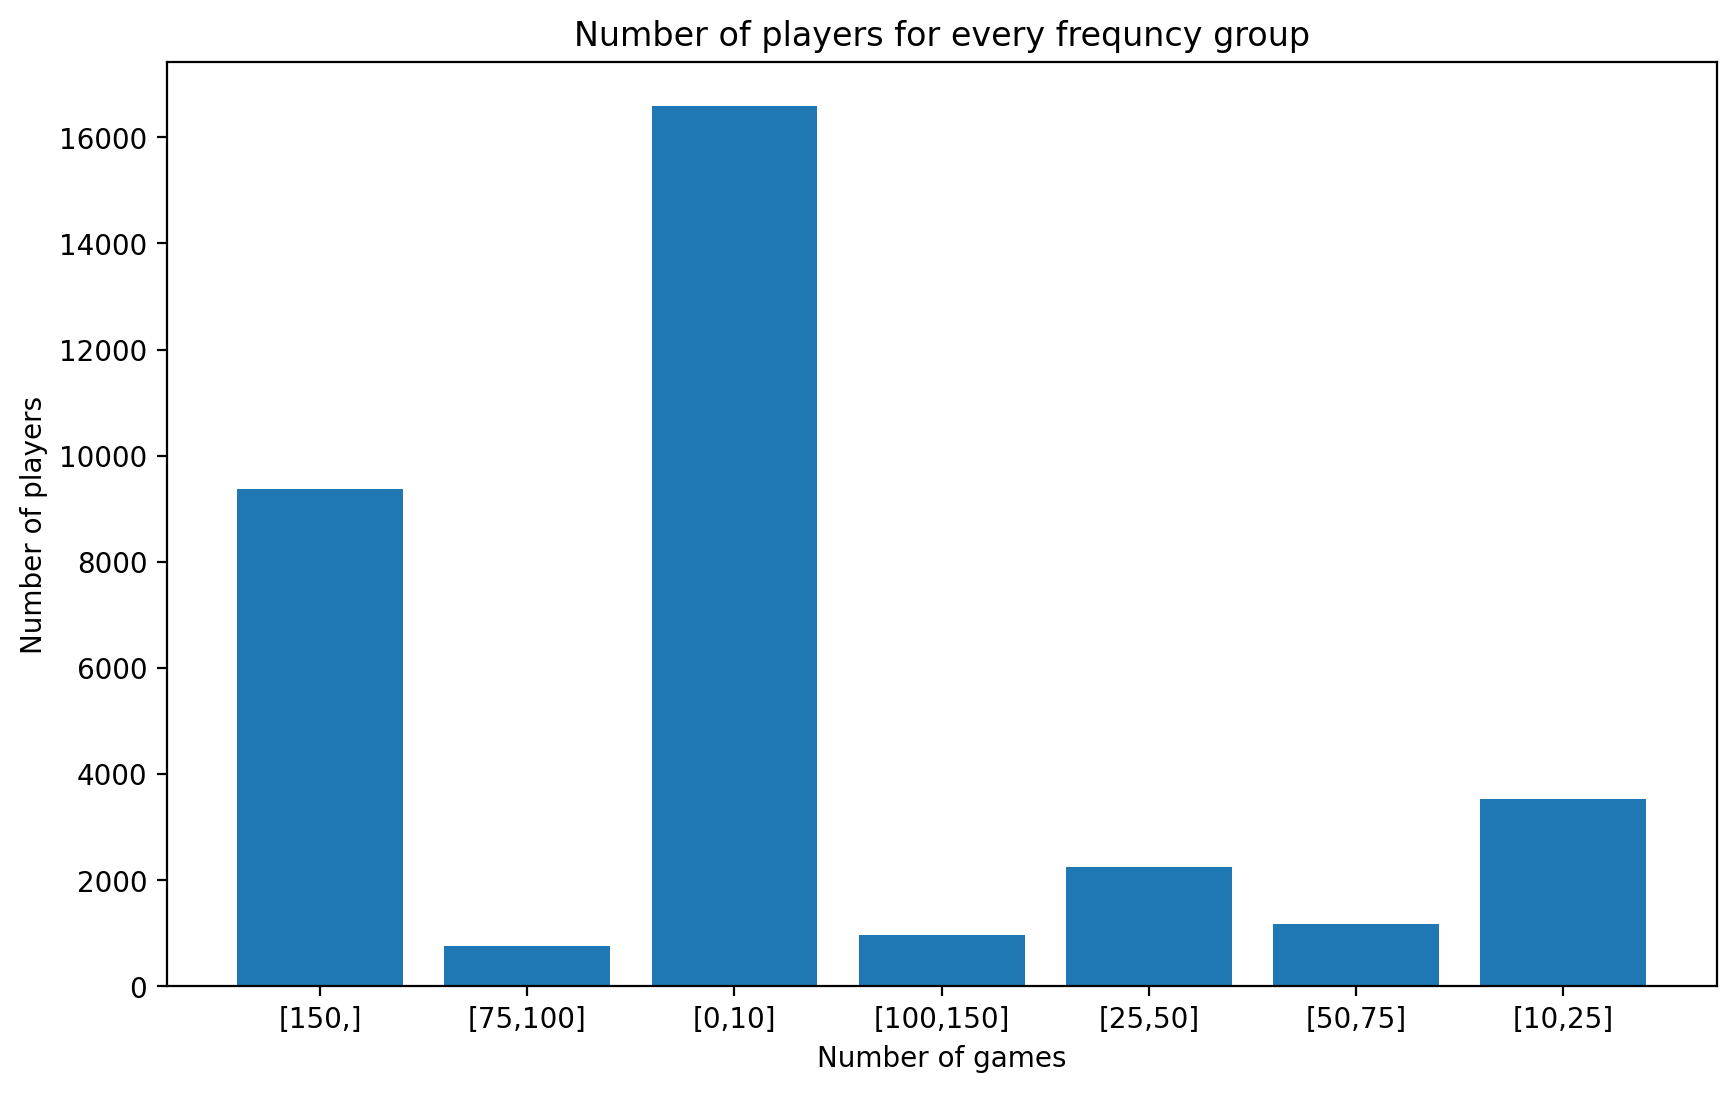

In [45]:
from collections import Counter
white_freq=Counter(list(df["White"]))
black_freq=Counter(list(df["Black"]))
all_freq=white_freq

for k,v in black_freq.items():
    all_freq[k]=all_freq.get(k,0)+v

count_freq={}
for k,v in all_freq.items():
    if v <=10:
        count_freq["[0,10]"]=count_freq.get("[0,10]",0)+1
    elif v <=25:
        count_freq["[10,25]"]=count_freq.get("[10,25]",0)+1
    elif v <=50:
        count_freq["[25,50]"]=count_freq.get("[25,50]",0)+1
    elif v <=75:
        count_freq["[50,75]"]=count_freq.get("[50,75]",0)+1
    elif v <=100:
        count_freq["[75,100]"]=count_freq.get("[75,100]",0)+1
    elif v <=150:
        count_freq["[100,150]"]=count_freq.get("[100,150]",0)+1
    else:
        count_freq["[150,]"]=count_freq.get("[150,]",0)+1

x = list(count_freq.keys())
y = list(count_freq.values())
plt.xlabel('Number of games')
plt.ylabel('Number of players')
plt.title('Number of players for every frequncy group')
plt.bar( x, y)
plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Number-of-players-for-every-frequncy-group.png")


### Number of games distributions per event type

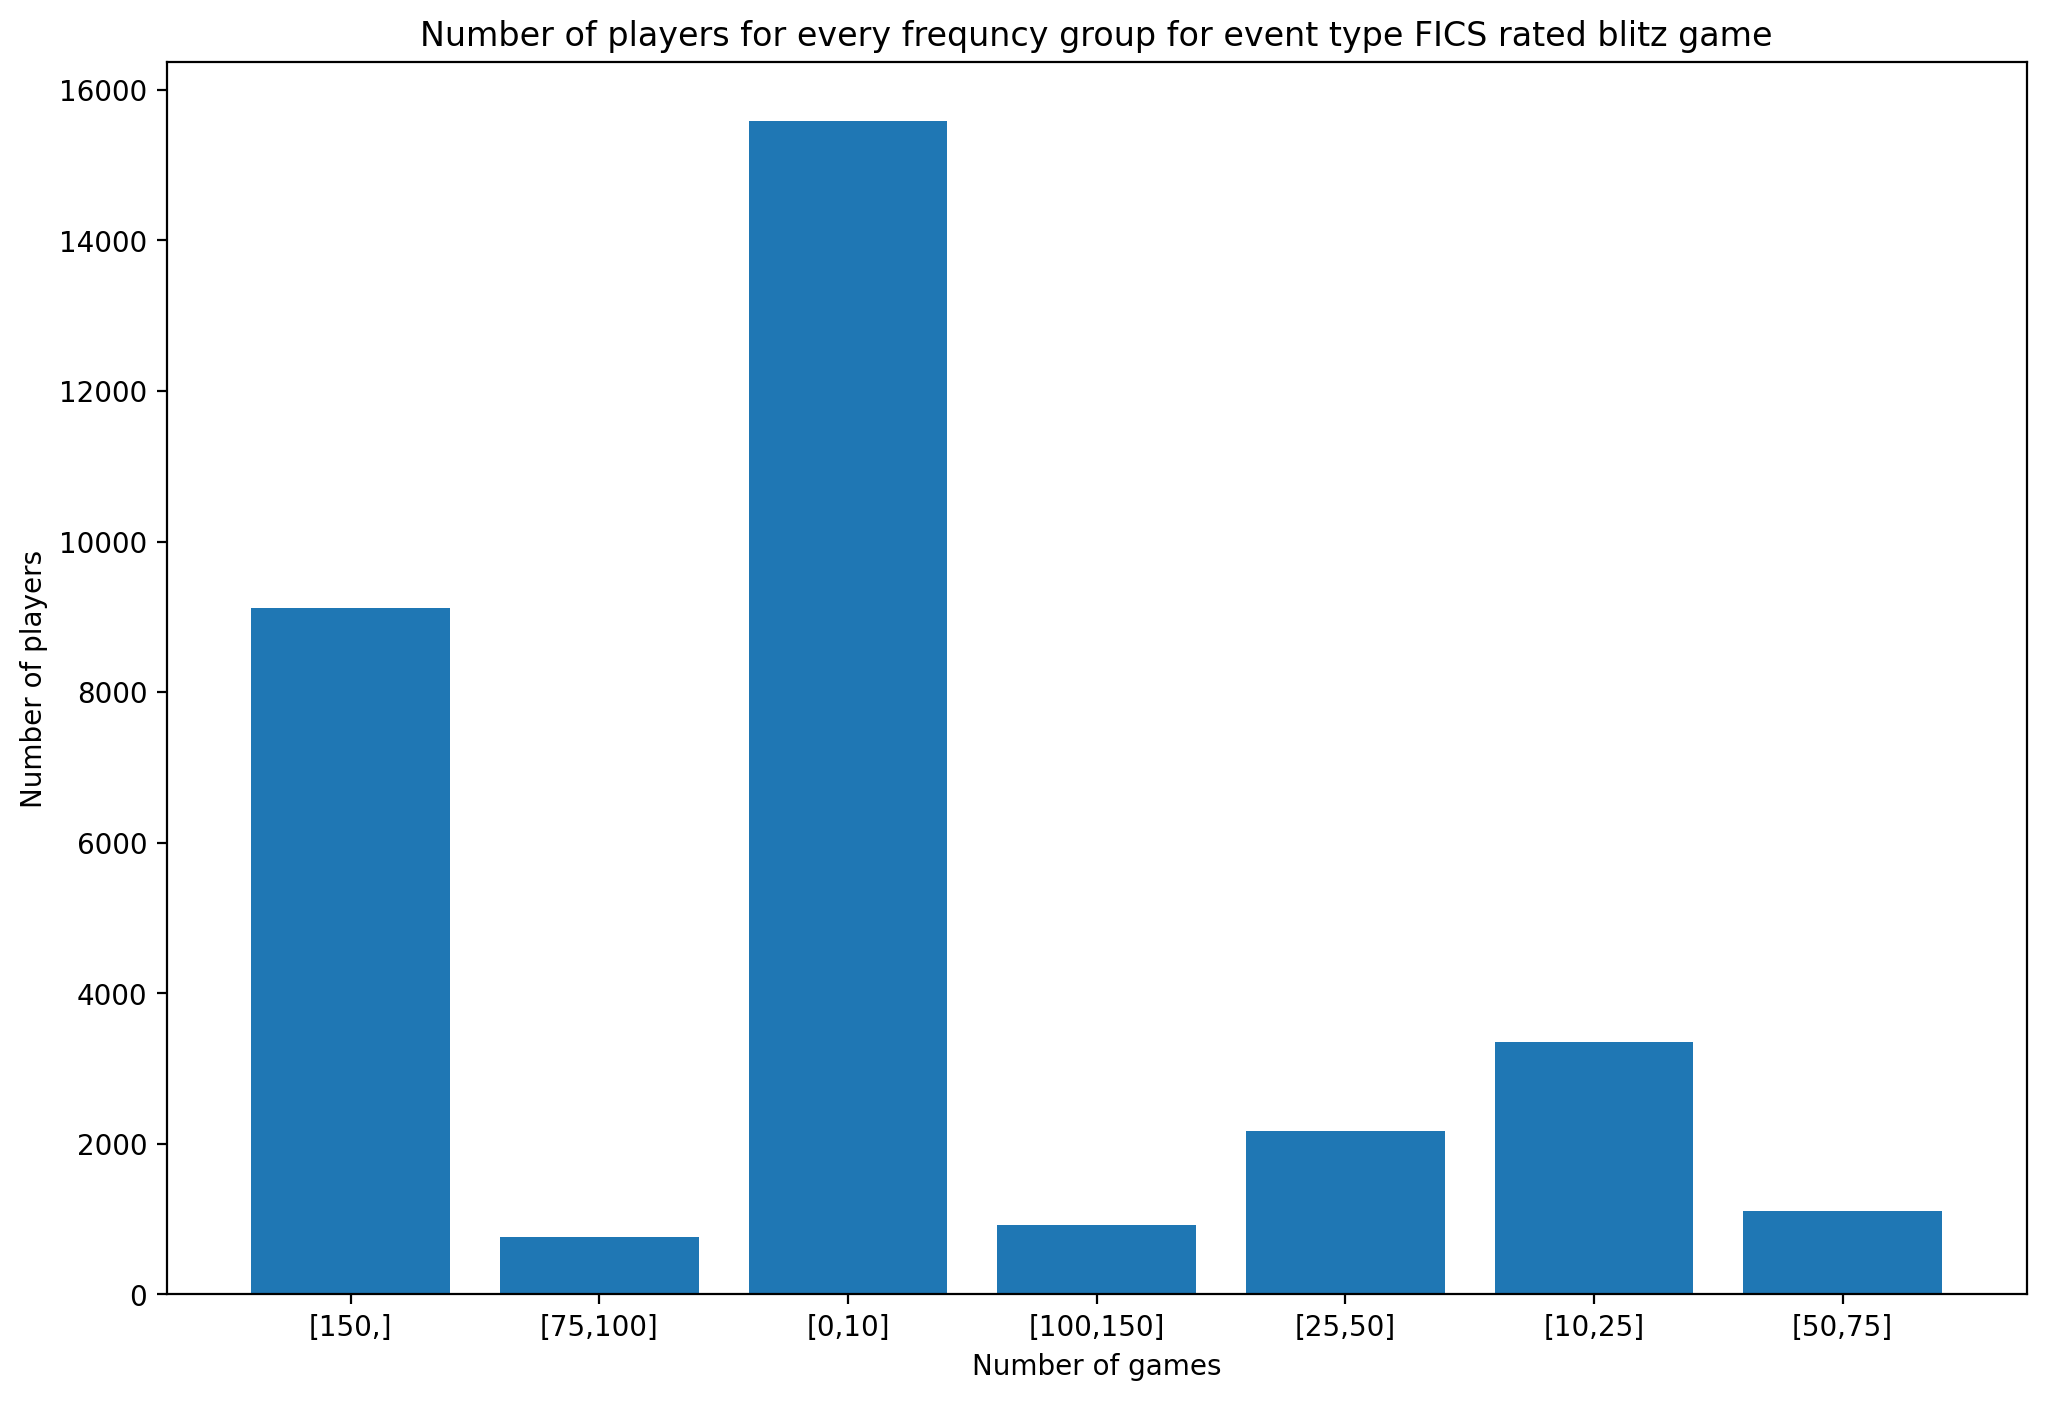

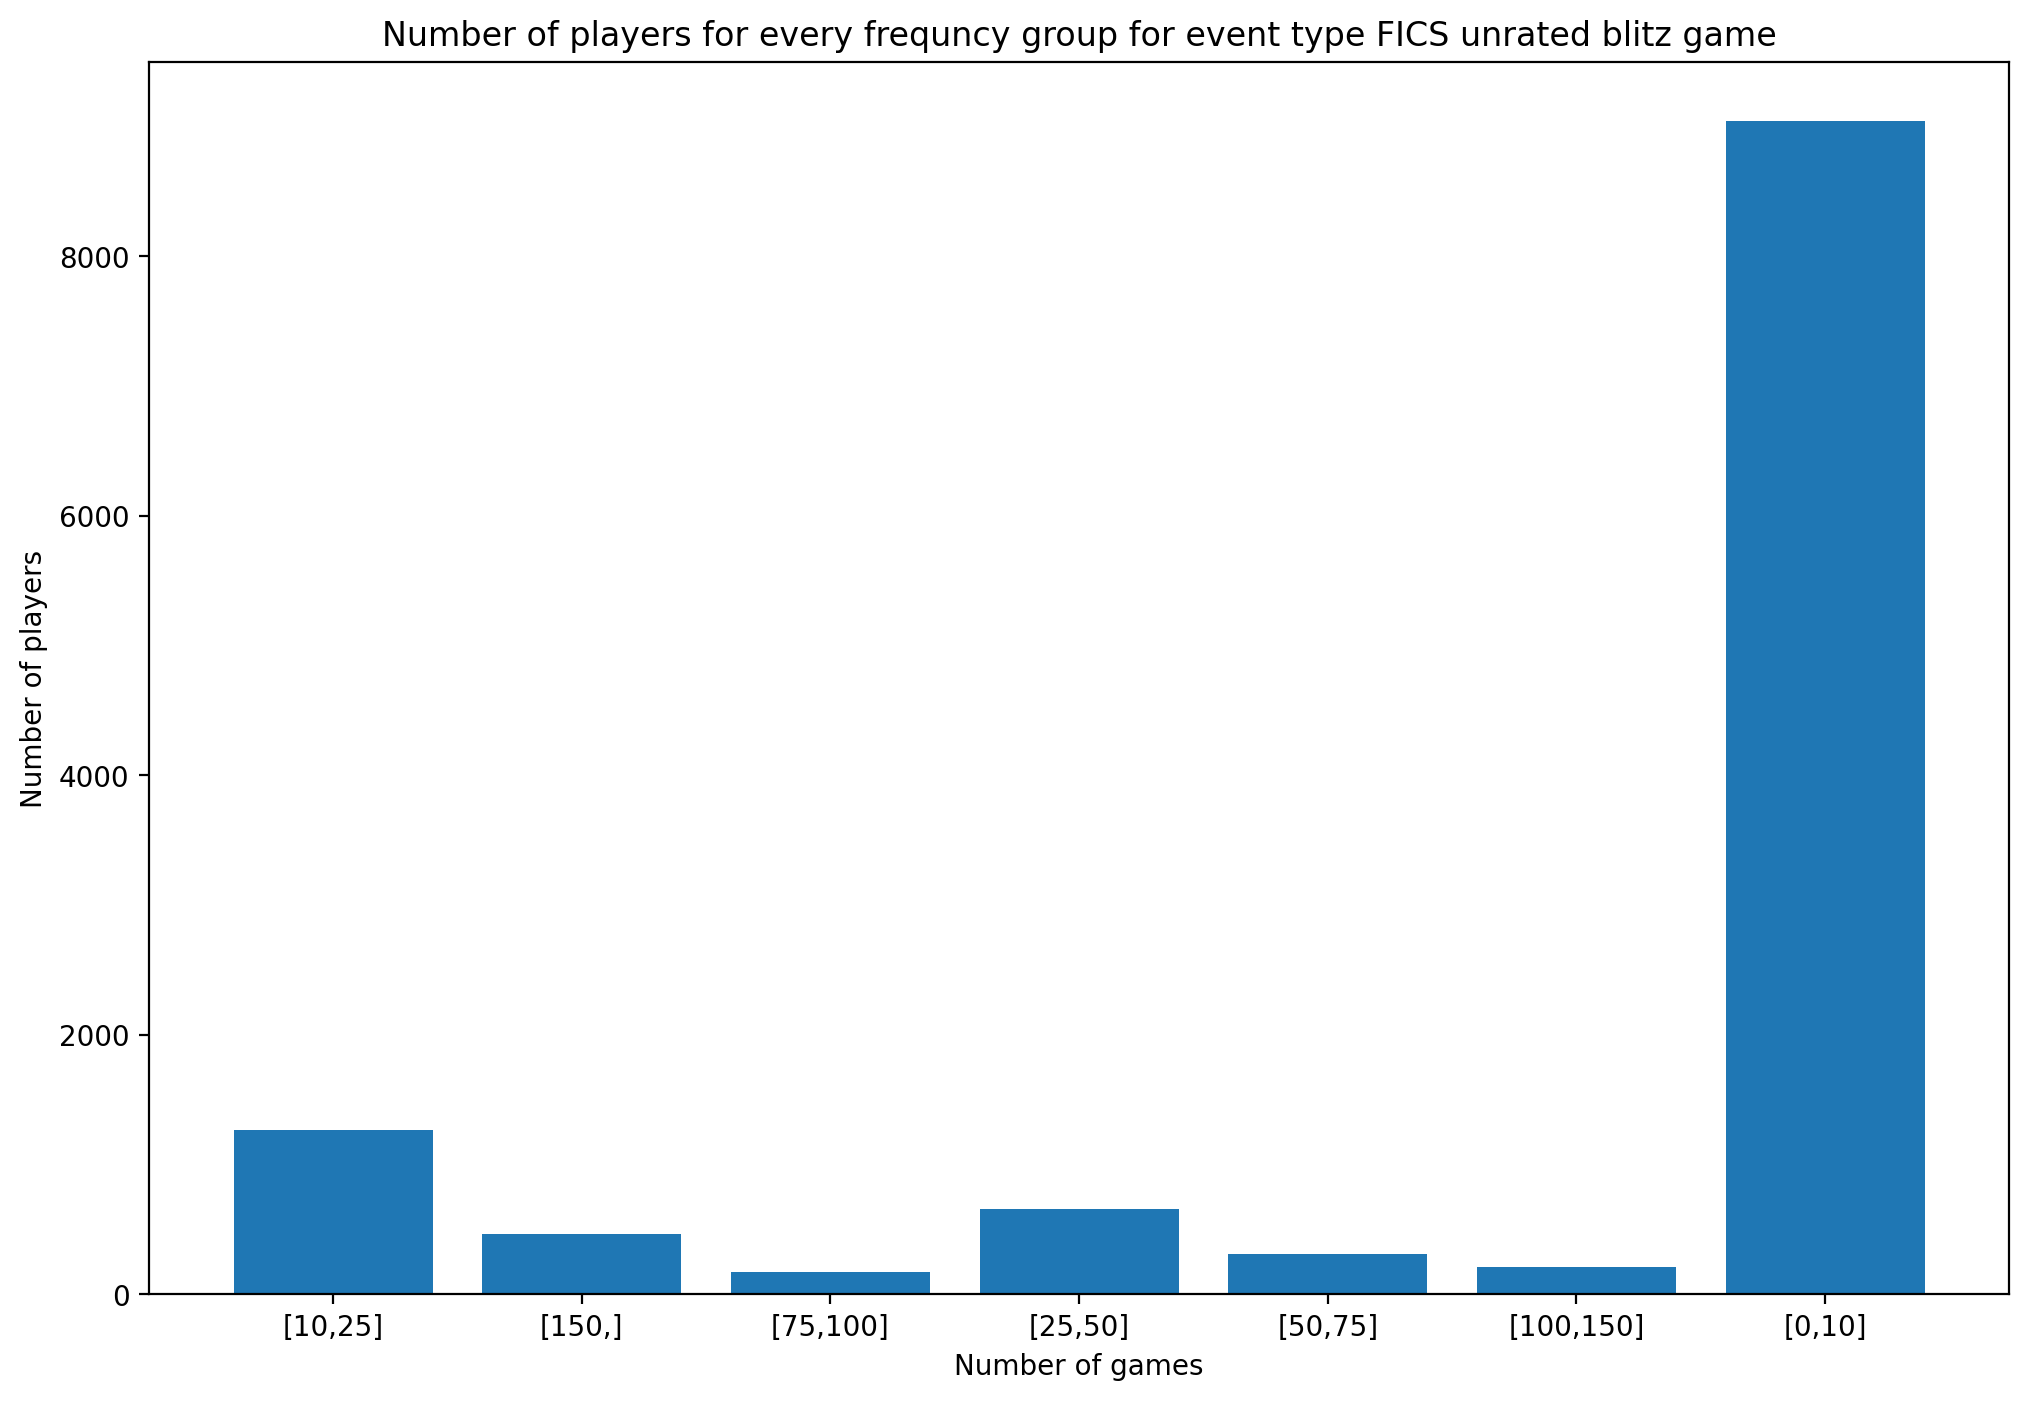

In [46]:
from collections import Counter

events=list(set(list(df["Event"])))


for e in events:
    df_e=df[df["Event"]==e]
    white_freq=Counter(list(df_e["White"]))
    black_freq=Counter(list(df_e["Black"]))
    all_freq=white_freq

    for k,v in black_freq.items():
        all_freq[k]=all_freq.get(k,0)+v

    count_freq={}
    for k,v in all_freq.items():
        if v <=10:
            count_freq["[0,10]"]=count_freq.get("[0,10]",0)+1
        elif v <=25:
            count_freq["[10,25]"]=count_freq.get("[10,25]",0)+1
        elif v <=50:
            count_freq["[25,50]"]=count_freq.get("[25,50]",0)+1
        elif v <=75:
            count_freq["[50,75]"]=count_freq.get("[50,75]",0)+1
        elif v <=100:
            count_freq["[75,100]"]=count_freq.get("[75,100]",0)+1
        elif v <=150:
            count_freq["[100,150]"]=count_freq.get("[100,150]",0)+1
        else:
            count_freq["[150,]"]=count_freq.get("[150,]",0)+1
    plt.figure(figsize=(12, 8))
    x = list(count_freq.keys())
    y = list(count_freq.values())
    plt.xlabel('Number of games')
    plt.ylabel('Number of players')
    plt.title(f'Number of players for every frequncy group for event type {e}')
    plt.bar( x, y)
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Number-of-players-for-every-frequncy-group-for-event-type-{e}.png")


Most of the players in the unrated games play a small number of moves so we will focus later on rated games

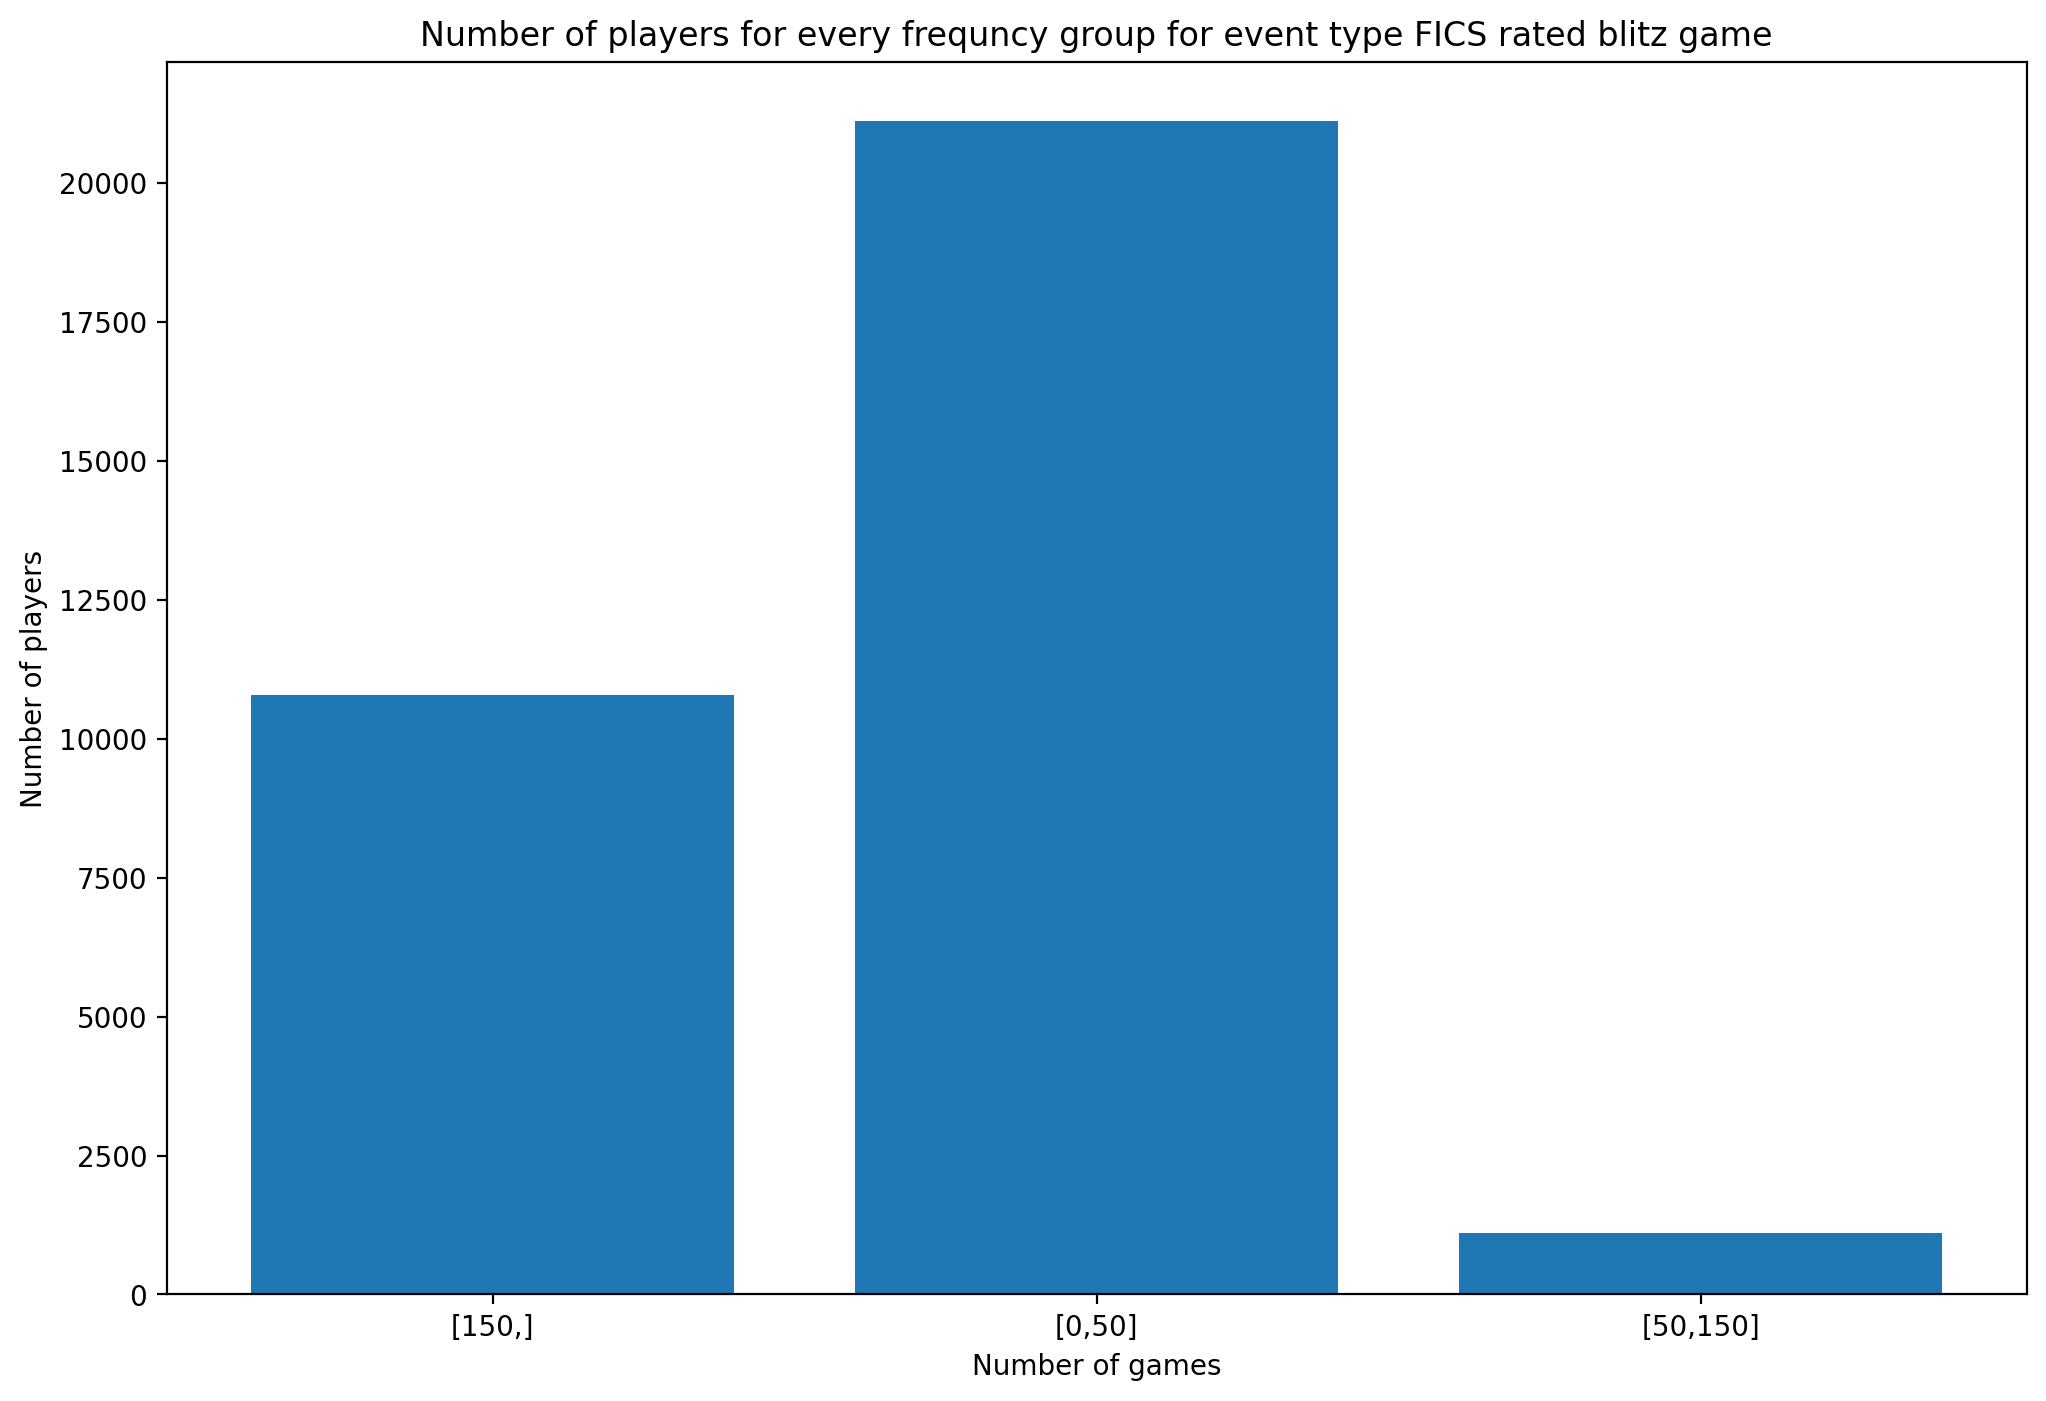

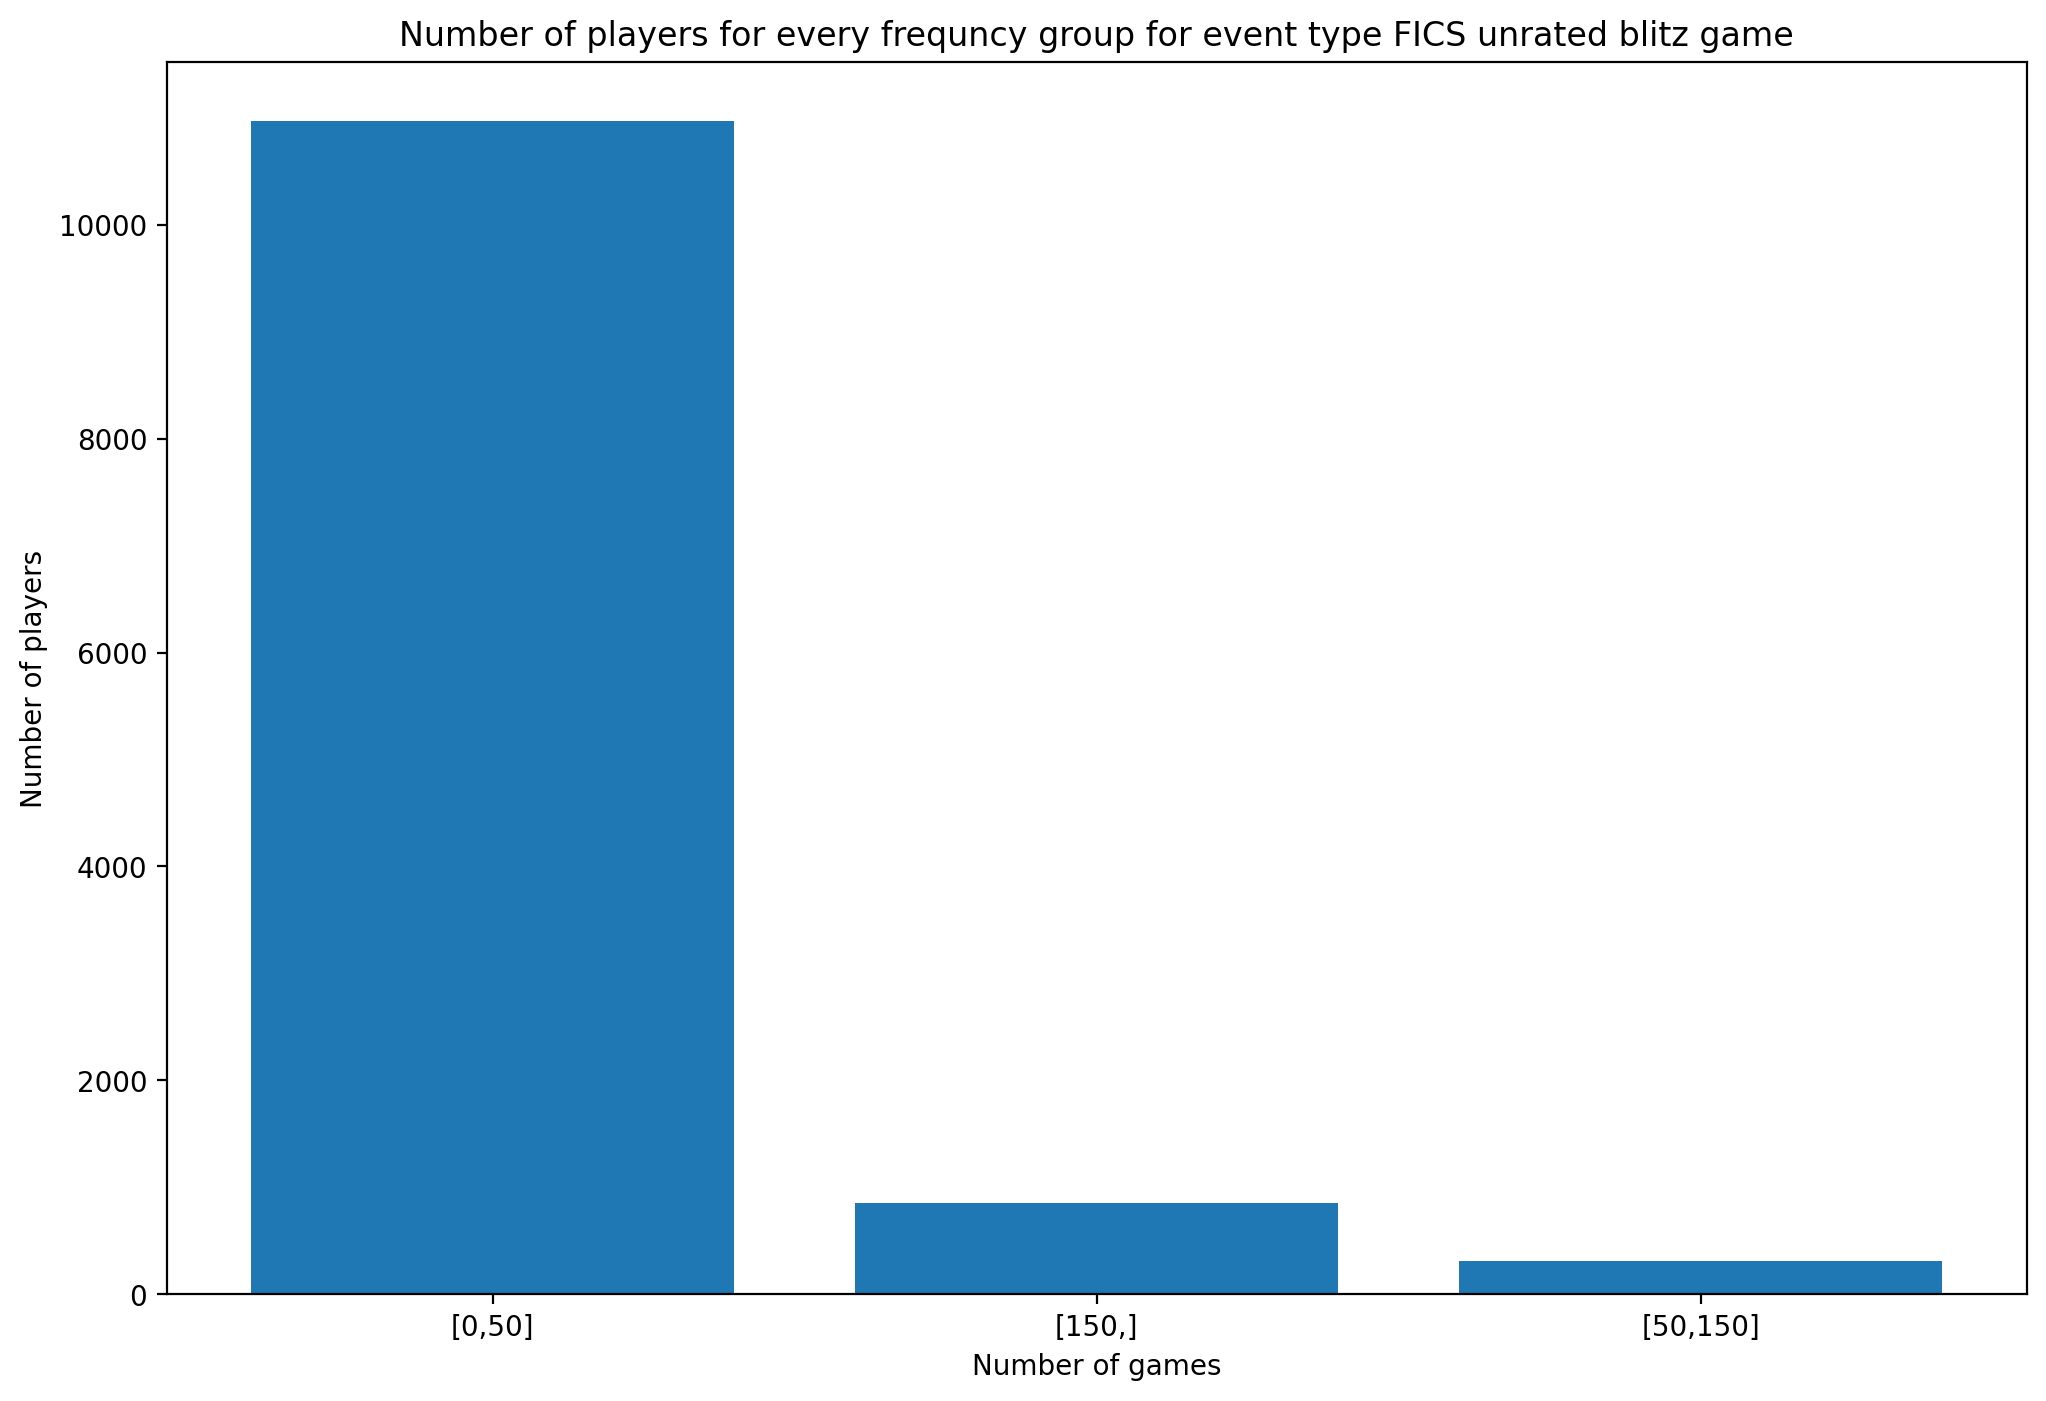

In [47]:
from collections import Counter

events=list(set(list(df["Event"])))


for e in events:
    df_e=df[df["Event"]==e]
    white_freq=Counter(list(df_e["White"]))
    black_freq=Counter(list(df_e["Black"]))
    all_freq=white_freq

    for k,v in black_freq.items():
        all_freq[k]=all_freq.get(k,0)+v

    count_freq={}
    for k,v in all_freq.items():
        if v <=50:
            count_freq["[0,50]"]=count_freq.get("[0,50]",0)+1
        elif v <=75:
            count_freq["[50,150]"]=count_freq.get("[50,150]",0)+1
        else:
            count_freq["[150,]"]=count_freq.get("[150,]",0)+1
    plt.figure(figsize=(12, 8))
    x = list(count_freq.keys())
    y = list(count_freq.values())
    plt.xlabel('Number of games')
    plt.ylabel('Number of players')
    plt.title(f'Number of players for every frequncy group for event type {e}')
    plt.bar( x, y)
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Number-of-players-for-every-frequncy-group-event-{e}-less_grouping.png")


We will focus on rated chess games

In [50]:
df=df[df["Event"]=="FICS rated blitz game"]
df=df.drop(columns="Event")
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal.csv")

In [51]:
df

,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,WhiteRD,BlackRD,TimeControl,Date,Time,...,BlackClock,ECO,PlyCount,Result,Move,Year,EloDiff,RelativeEloDiff,ECO_class,Winning status
0,455505130,Strikko,boggus,1606,1607,23.3,22.4,180+0,2019.11.30,08:05:00,...,0:03:00.000,A27,156,0-1,| Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...,2019,-1,-0.03,A,forfeit
1,455505129,Wychbold,Jarlaxle,1311,1437,27.7,24.1,180+0,2019.11.30,08:07:00,...,0:03:00.000,B21,60,0-1,| e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...,2019,-126,-4.59,B,resign
2,455505128,Shaderman,tihibuda,1567,1516,53.1,27.5,180+0,2019.11.30,08:06:00,...,0:03:00.000,B06,75,1-0,| e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...,2019,51,1.65,B,forfeit
3,455505126,aussenschnapp,SchachDieter,1680,1698,19.5,22.9,180+0,2019.11.30,08:05:00,...,0:03:00.000,A43,109,1-0,| d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...,2019,-18,-0.53,A,mate
4,455505123,pfink,Tojul,1288,1174,26.2,46.2,600+0,2019.11.30,07:56:00,...,0:10:00.000,B94,71,0-1,| e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...,2019,114,4.63,B,resign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14717855,434845469,Arembepe,bretteux,1059,1155,46.6,28.1,180+1,2018.08.09,12:16:00,...,0:03:00.000,B20,47,1-0,| e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...,2018,-96,-4.34,B,resign
14717856,434845468,JonotheRed,HWPer,1501,1520,27.1,33.7,300+0,2018.08.09,12:12:00,...,0:05:00.000,C01,109,1-0,| e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...,2018,-19,-0.63,C,resign
14717857,434845467,snackking,Jonfern,1621,1676,18.9,26.6,180+0,2018.08.09,12:13:00,...,0:03:00.000,C50,80,0-1,| e4 e5 | Nf3 Nc6 | Bc4 Be7 | O-O Nf6 | Re1 O-...,2018,-55,-1.67,C,forfeit
14717858,434845465,alza,Jesuslovesall,1333,1423,19.9,21.0,300+0,2018.08.09,12:14:00,...,0:05:00.000,B01,42,0-1,| e4 d5 | e5 c5 | d4 Nc6 | dxc5 Nxe5 | Nf3 Nc6...,2018,-90,-3.27,B,resign


In [3]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal.csv")

## 4.2 Players games distributions

In [4]:
def get_players_by_num_games_dist(df):
    white_player_dist=dict(Counter(df["White"]))
    black_player_dist=dict(Counter(df["Black"]))

    players_dict={k:v for k,v in white_player_dist.items()}
    for k,v in black_player_dist.items():
        players_dict[k]=players_dict.get(k,0)+black_player_dist[k]
    result_dict={"Player":list(players_dict.keys()),"NumberOfGames":list(players_dict.values())}
    return pd.DataFrame.from_dict(result_dict).sort_values(by="NumberOfGames",ascending=False)

GAMES_COUNT_CATEGORY={
    "[0,10)":[0,9],
    "[10,50)":[10,49],
    "[50,100)":[50,99],
    "[100,200)":[100,199],
    "[200,500)":[200,499],
    "[500,1000)":[500,999],
    "[1000,10000)":[1000,9999],
    "[10000,100000)":[10000,99999],
    "[100000,1000000)":[100000,999999],
    "[1000000,)":[1000000,99999999999],
}

def get_label(categories,num_games):
    labels=list(categories.keys())
    all_ranges=list(categories.values())

    if num_games>all_ranges[-1][0]:
        return labels[-1]
    
    for i in range(0,len(all_ranges)-1):
        if num_games>=all_ranges[i][0] and num_games<all_ranges[i+1][0]: 
            return labels[i]

,Player,NumberOfGames,Class
24,inemuri,209148,"[100000,1000000)"
22,IFDTitan,158728,"[100000,1000000)"
95,IFDThor,129767,"[100000,1000000)"
2074,GringoEngine,111954,"[100000,1000000)"
68,forlat,87014,"[10000,100000)"
...,...,...,...
18880,viznu,1,"[0,10)"
18878,Muris,1,"[0,10)"
18877,Razzler,1,"[0,10)"
18876,rajivreddykasarla,1,"[0,10)"


Class
[0,10)              15156
[10,50)              5901
[1000,10000)         4466
[200,500)            1964
[50,100)             1893
[100,200)            1578
[500,1000)           1426
[10000,100000)        622
[100000,1000000)        4
Name: count, dtype: int64


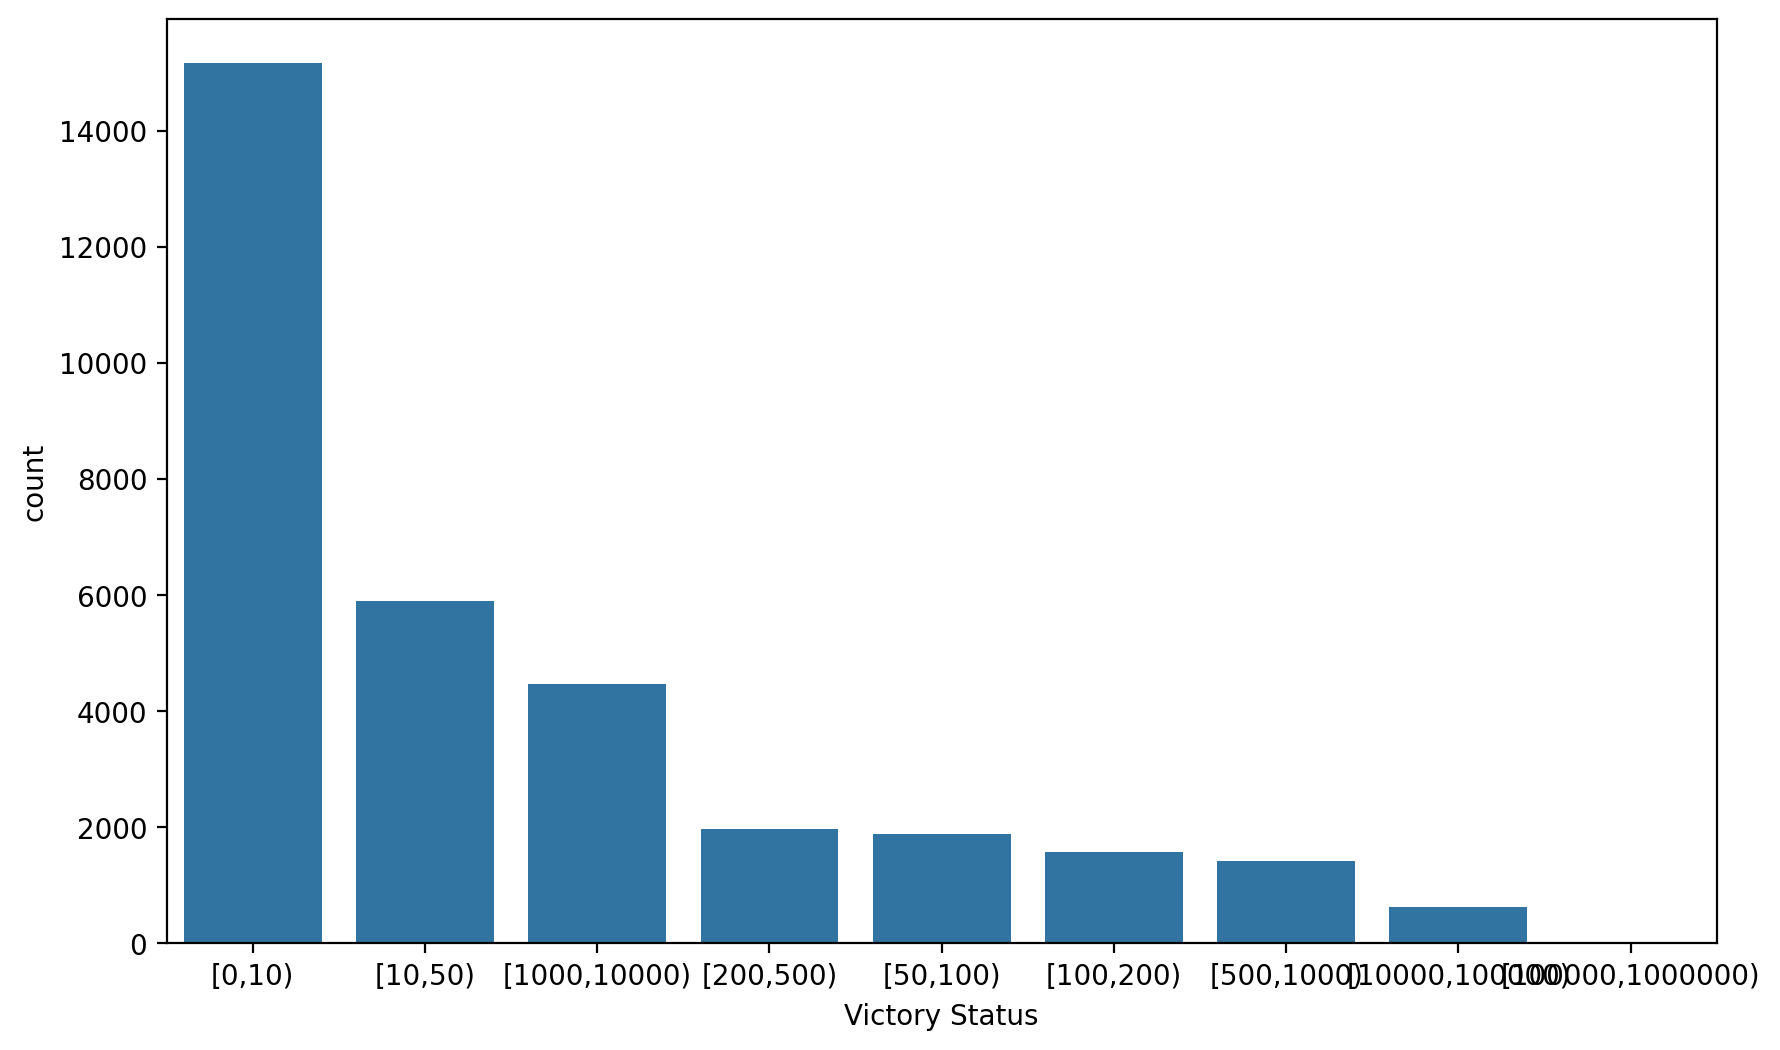

In [6]:

# we will get number of games per player
num_games_df=get_players_by_num_games_dist(df)
num_games_df["Class"]=num_games_df["NumberOfGames"].apply(lambda g:get_label(GAMES_COUNT_CATEGORY,g))
display(num_games_df)

# distribution of game status in a bar chart
status_order = num_games_df['Class'].value_counts().index
sb.countplot(data=num_games_df, x='Class', color=base_color, order=status_order);
plt.xlabel('Victory Status');
print(num_games_df['Class'].value_counts())

We dont have interest in players that have played really small number of games

In [7]:
player_to_use=list(num_games_df[num_games_df["NumberOfGames"]>=NUMBER_OF_GAMES_MINIMUM]["Player"])

In [17]:
df=df[(df["White"].isin(player_to_use))|(df["Black"].isin(player_to_use))]

In [29]:
num_games_df=get_players_by_num_games_dist(df)
num_games_df=num_games_df[num_games_df["Player"].isin(player_to_use)]

We will make sure that we only use human players

In [13]:
import requests
import html
def is_bot(player):
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:122.0) Gecko/20100101 Firefox/122.0',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'Referer': 'https://www.ficsgames.org/',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
        'Sec-Fetch-Dest': 'document',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-Site': 'same-origin',
    }

    response = requests.get(f'https://www.ficsgames.org/cgi-bin/search.cgi?player={player}&action=Finger', headers=headers)
    content=html.unescape(response.text)
    for line in content.split("\n"):
        if "bot" in line:
            return True
    return False


In [34]:
import concurrent.futures
import time

players_human={}
players=player_to_use

def thread_function(players,id,num_threads):
    for i in range(len(players)):
        if i%num_threads==id:
            players_human[players[i]]=is_bot(players[i])
            print(len((players_human.keys())))

# Create a ThreadPoolExecutor with 3 worker threads
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    # Submit tasks to the executor
    tasks = [executor.submit(thread_function, players,i,10) for i in range(10)]
    
    # Wait for all tasks to complete
    for future in concurrent.futures.as_completed(tasks):
        # Retrieve the result of each task
        result = future.result()
        print("Task result:", result)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147148

149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [14]:
num_games_df["Bot"]=num_games_df["Player"].apply(lambda p:players_human[p])
num_games_df=num_games_df[num_games_df["Bot"]==False]
player_to_use=list(num_games_df["Player"])
df=df[(df["White"].isin(player_to_use))|(df["Black"].isin(player_to_use))]

## 5 Reformat data

In [18]:
def white_side(result):
    if result=="0-1":
        return "Won"
    elif result=="1-0":
        return "Lost"
    else:
        return "Tie" 

def black_side(result):
    if result=="1-0":
        return "Won"
    elif result=="0-1":
        return "Lost"
    else:
        return "Tie" 


def reformat_to_players_df(df,players):

    try:
        df=df[(df["White"].isin(players))|(df["Black"].isin(players))]

        #
        df1=df[(df["White"].isin(players))&(df["Black"].isin(players))]
        df1=df1[["Result","FICSGamesDBGameNo","White","WhiteElo","Black","BlackElo","UTCDate","UTCTime"]].rename(columns={
            "White":"Player",
            "WhiteElo":"Elo",
            "Black":"Opponent",
            "BlackElo":"OpponentElo",
        })
        df1["Result"]=df1["Result"].apply(lambda r:white_side(r))

        df2=df[(df["White"].isin(players))&(~df["Black"].isin(players))]
        df2=df2[["Result","FICSGamesDBGameNo","White","WhiteElo","Black","BlackElo","UTCDate","UTCTime"]].rename(columns={
            "White":"Player",
            "WhiteElo":"Elo",
            "Black":"Opponent",
            "BlackElo":"OpponentElo",

        
        })
        df2["Result"]=df2["Result"].apply(lambda r:white_side(r))

        #
        df3=df[(~df["White"].isin(players))&(df["Black"].isin(players))]
        df3=df3[["Result","FICSGamesDBGameNo","Black","BlackElo","White","WhiteElo","UTCDate","UTCTime"]].rename(columns={
            "Black":"Player",
            "BlackElo":"Elo",
                "White":"Opponent",
            "WhiteElo":"OpponentElo",

        
        })
        df3["Result"]=df3["Result"].apply(lambda r:black_side(r))

        #
        df4=df[(df["White"].isin(players))&(df["Black"].isin(players))]
        df4=df4[["Result","FICSGamesDBGameNo","Black","BlackElo","White","WhiteElo","UTCDate","UTCTime"]].rename(columns={
            "Black":"Player",
            "BlackElo":"Elo",
                "White":"Opponent",
            "WhiteElo":"OpponentElo",
        })

        df4["Result"]=df4["Result"].apply(lambda r:black_side(r))

        df=pd.concat([df1,df2,df3,df4])
    except Exception as err:
        df=df[(df["White"].isin(players))|(df["Black"].isin(players))]
        df1=df[(df["White"].isin(players))&(df["Black"].isin(players))]
        df1=df1[["Result","FICSGamesDBGameNo","White","WhiteElo","Black","BlackElo","Date","Time"]].rename(columns={
            "White":"Player",
            "WhiteElo":"Elo",
            "Black":"Opponent",
            "BlackElo":"OpponentElo",
        })
        df1["Result"]=df1["Result"].apply(lambda r:white_side(r))

        df2=df[(df["White"].isin(players))&(~df["Black"].isin(players))]
        df2=df2[["Result","FICSGamesDBGameNo","White","WhiteElo","Black","BlackElo","Date","Time"]].rename(columns={
            "White":"Player",
            "WhiteElo":"Elo",
            "Black":"Opponent",
            "BlackElo":"OpponentElo",

        
        })
        df2["Result"]=df2["Result"].apply(lambda r:white_side(r))

        #
        df3=df[(~df["White"].isin(players))&(df["Black"].isin(players))]
        df3=df3[["Result","FICSGamesDBGameNo","Black","BlackElo","White","WhiteElo","Date","Time"]].rename(columns={
            "Black":"Player",
            "BlackElo":"Elo",
                "White":"Opponent",
            "WhiteElo":"OpponentElo",

        
        })
        df3["Result"]=df3["Result"].apply(lambda r:black_side(r))

        #
        df4=df[(df["White"].isin(players))&(df["Black"].isin(players))]
        df4=df4[["Result","FICSGamesDBGameNo","Black","BlackElo","White","WhiteElo","Date","Time"]].rename(columns={
            "Black":"Player",
            "BlackElo":"Elo",
                "White":"Opponent",
            "WhiteElo":"OpponentElo",
        })
        df4["Result"]=df4["Result"].apply(lambda r:black_side(r))

        #
        df=pd.concat([df1,df2,df3,df4])
    df=df.dropna()
    df["Year"]=df["Date"].apply(lambda r:int(str(r).split(".")[0]))
    df["Month"]=df["Date"].apply(lambda r:int(str(r).split(".")[1]))
    df["Day"]=df["Date"].apply(lambda r:int(str(r).split(".")[2]))
    df["Hour"]=df["Time"].apply(lambda r:int(str(r).split(":")[0]))
    df["Minute"]=df["Time"].apply(lambda r:int(str(r).split(":")[1]))
    df["Second"]=df["Time"].apply(lambda r:int(str(r).split(":")[2]))

    return df


In [19]:
df

,Unnamed: 0,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,WhiteRD,BlackRD,TimeControl,Date,...,BlackClock,ECO,PlyCount,Result,Move,Year,EloDiff,RelativeEloDiff,ECO_class,Winning status
0,0,455505130,Strikko,boggus,1606,1607,23.3,22.4,180+0,2019.11.30,...,0:03:00.000,A27,156,0-1,| Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...,2019,-1,-0.03,A,forfeit
1,1,455505129,Wychbold,Jarlaxle,1311,1437,27.7,24.1,180+0,2019.11.30,...,0:03:00.000,B21,60,0-1,| e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...,2019,-126,-4.59,B,resign
2,2,455505128,Shaderman,tihibuda,1567,1516,53.1,27.5,180+0,2019.11.30,...,0:03:00.000,B06,75,1-0,| e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...,2019,51,1.65,B,forfeit
3,3,455505126,aussenschnapp,SchachDieter,1680,1698,19.5,22.9,180+0,2019.11.30,...,0:03:00.000,A43,109,1-0,| d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...,2019,-18,-0.53,A,mate
4,4,455505123,pfink,Tojul,1288,1174,26.2,46.2,600+0,2019.11.30,...,0:10:00.000,B94,71,0-1,| e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...,2019,114,4.63,B,resign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14408055,14717855,434845469,Arembepe,bretteux,1059,1155,46.6,28.1,180+1,2018.08.09,...,0:03:00.000,B20,47,1-0,| e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...,2018,-96,-4.34,B,resign
14408056,14717856,434845468,JonotheRed,HWPer,1501,1520,27.1,33.7,300+0,2018.08.09,...,0:05:00.000,C01,109,1-0,| e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...,2018,-19,-0.63,C,resign
14408057,14717857,434845467,snackking,Jonfern,1621,1676,18.9,26.6,180+0,2018.08.09,...,0:03:00.000,C50,80,0-1,| e4 e5 | Nf3 Nc6 | Bc4 Be7 | O-O Nf6 | Re1 O-...,2018,-55,-1.67,C,forfeit
14408058,14717858,434845465,alza,Jesuslovesall,1333,1423,19.9,21.0,300+0,2018.08.09,...,0:05:00.000,B01,42,0-1,| e4 d5 | e5 c5 | d4 Nc6 | dxc5 Nxe5 | Nf3 Nc6...,2018,-90,-3.27,B,resign


In [20]:
reformat_to_players_df(df,player_to_use).to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-players.csv")

In [21]:
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-details.csv")

# 5. Conclutions
